<a href="https://colab.research.google.com/github/ashpakshaikh26732/Unet-FCN/blob/main/Unet_FCN91.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**all packages**

In [ ]:
!pip install --upgrade tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 96.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 99.5 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.18.0
    Uninstalling tensorboard-2.18.0:
      Successfully uninstalled tensorboard-2.18.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.18.0
    Uninstalling tensorflow-2.18.0:
      Successfully uninstalled tensorflow-2.18.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.18.0 requires tensorflow<2.19,>=2.18, but you have tensorflow 2.19.0 w

In [9]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

from IPython.display import display,HTML

In [8]:
!pip install tensorflow==2.18.0
!pip install tensorflow-tpu==2.18.0 --find-links=https://storage.googleapis.com/libtpu-tf-releases/index.html

import tensorflow as tf

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='local')
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
    print("TPU is running:", tpu.master())
except ValueError as e:
    print("TPU is not avaible:", e)

Looking in links: https://storage.googleapis.com/libtpu-tf-releases/index.html
TPU is running: 


In [ ]:
print(f'Number of TPUs: {strategy.num_replicas_in_sync}')

In [ ]:
import tensorflow as tf


print(f'TensorFlow version: {tf.__version__}')

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
  print(f'TPU cluster resolved: {tpu.cluster_spec()}')
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.TPUStrategy(tpu)
  print(f'Number of TPUs: {strategy.num_replicas_in_sync}')
except Exception as e:
  print(f'TPU failed to initialize: {e}')

**mixed precision training**

In [ ]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

In [ ]:
tf.config.run_functions_eagerly(False)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

**copy datasets from drive**

In [4]:
!cp /content/drive/MyDrive/cityscap/Cityscapes/gtFine_trainvaltest.zip /content/
!cp /content/drive/MyDrive/cityscap/Cityscapes/leftImg8bit_trainvaltest.zip /content

**extract trainig the data**

In [5]:

os.system("unzip -q /content/gtFine_trainvaltest.zip -d /content/ ")
os.system("unzip -q /content/leftImg8bit_trainvaltest.zip -d /content/")

256

In [10]:
print("Train Images:", len(os.listdir("/content/leftImg8bit/train/")))
print("Train Labels:", len(os.listdir("/content/gtFine/train/")))

Train Images: 18
Train Labels: 18


In [11]:
print("test images : ", len(os.listdir('/content/leftImg8bit/test')))

test images :  6


**Global Valrible**

In [12]:
img_height = 512
img_width = 512
batch_size = 8
final_batch_size = batch_size * strategy.num_replicas_in_sync


**loading images and labels from directry for training**

In [13]:
def load_img():
    train_dir = '/content/leftImg8bit/train'
    train_image_cities = os.listdir(train_dir)
    train_images = []
    for city in sorted(train_image_cities):
        train_city = os.path.join(train_dir, city)
        images = sorted([os.path.join(train_city, img) for img in os.listdir(train_city) if img.endswith('.png')])
        train_images.extend(images)
    return train_images

def load_labels():
    train_dir = '/content/gtFine/train'
    train_labels_cities = os.listdir(train_dir)
    train_labels = []
    for city in sorted(train_labels_cities):
        train_city_label = os.path.join(train_dir, city)
        labels = sorted([os.path.join(train_city_label, f) for f in os.listdir(train_city_label) if f.endswith('_gtFine_labelIds.png')])
        train_labels.extend(labels)
    return train_labels

**reading images from path**

In [14]:
def read_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_png(img, channels=3)
    img = tf.image.resize(img, (img_height, img_width))
    img = img / 255.0
    return img

def read_labels(label_path):
    label = tf.io.read_file(label_path)
    label = tf.io.decode_png(label, channels=1)
    label = tf.image.resize(label, (img_height, img_width), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return tf.cast(label, tf.uint8)

**augmentation**

In [15]:
def process_data(image_path, label_path):
    image = read_img(image_path)
    label = read_labels(label_path)
    return image, label

def augment(image, label):
    label = tf.cast(label, tf.float32)
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        label = tf.image.flip_left_right(label)
    image = tf.image.random_brightness(image, max_delta=0.1)
    label = tf.cast(label, tf.uint8)
    return image, label

**creating dataset**

In [16]:
def map_labels_tf(label):
    label = tf.squeeze(label, axis=-1)

    original_ids = tf.constant([7, 8, 11, 12, 13, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33], dtype=tf.int32)
    train_ids = tf.range(19, dtype=tf.int32)
    lookup = tf.fill([34], 255)
    lookup = tf.tensor_scatter_nd_update(lookup, tf.expand_dims(original_ids, axis=1), train_ids)
    y_mapped = tf.gather(lookup, tf.cast(label, tf.int32))
    return tf.expand_dims(y_mapped, axis=-1)

images = load_img()
labels = load_labels()
assert len(images) == len(labels), f"Mismatch: {len(images)} images, {len(labels)} labels"
print("Total Train Images:", len(images))
print("Total Train Labels:", len(labels))

def replace_ignore_label(image, label):
    label = tf.where(label == 255, 0, label)  # label is int32, so 255 and 0 are fine
    return image, label


train_dataset = tf.data.Dataset.from_tensor_slices((images, labels))
options = tf.data.Options()
options.experimental_deterministic = False  # Allow non-deterministic order for better performance
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.DATA  # Shard data across TPU replicas

# Apply options to the dataset
train_dataset = train_dataset.with_options(options)

train_dataset = train_dataset.map(process_data, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset =train_dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.map(lambda image, label: (image, map_labels_tf(label)), num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.map(replace_ignore_label, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size=100).cache().batch(final_batch_size,drop_remainder=True)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
train_dataset = strategy.experimental_distribute_dataset(train_dataset)

Total Train Images: 2975
Total Train Labels: 2975


**loading images and labels from directry for validiation**

In [17]:
def load_img_val():
    train_dir = '/content/leftImg8bit/val'
    train_image_cities = os.listdir(train_dir)
    train_images = []

    for city in sorted(train_image_cities):
        train_city = os.path.join(train_dir, city)
        images = sorted([os.path.join(train_city, img) for img in os.listdir(train_city) if img.endswith('.png')])
        train_images.extend(images)

    return train_images

def load_labels_val():
    train_dir = '/content/gtFine/val'
    train_labels_cities = os.listdir(train_dir)
    train_labels = []
    for city in sorted(train_labels_cities):
        train_city_label = os.path.join(train_dir, city)
        labels = sorted([os.path.join(train_city_label, f) for f in os.listdir(train_city_label) if f.endswith('_gtFine_labelIds.png')])
        train_labels.extend(labels)
    return train_labels

In [18]:
def read_img_val(img_path):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_png(img, channels=3)
    img = tf.image.resize(img, (img_height, img_width))
    img = img / 255.0
    return img

def read_labels_val(label_path):
    label = tf.io.read_file(label_path)
    label = tf.io.decode_png(label, channels=1)
    label = tf.image.resize(label, (img_height, img_width), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return tf.cast(label, tf.uint8)

In [19]:
def process_data_val(image_path, label_path):
    image = read_img(image_path)
    label = read_labels(label_path)
    return image, label

def map_labels_tf(label):
    label = tf.squeeze(label, axis=-1)

    original_ids = tf.constant([7, 8, 11, 12, 13, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33], dtype=tf.int32)
    train_ids = tf.range(19, dtype=tf.int32)
    lookup = tf.fill([34], 255)
    lookup = tf.tensor_scatter_nd_update(lookup, tf.expand_dims(original_ids, axis=1), train_ids)
    y_mapped = tf.gather(lookup, tf.cast(label, tf.int32))
    return tf.expand_dims(y_mapped, axis=-1)

images = load_img_val()
labels = load_labels_val()
assert len(images) == len(labels), f"Mismatch: {len(images)} images, {len(labels)} labels"
print("Total Train Images:", len(images))
print("Total Train Labels:", len(labels))

def replace_ignore_label(image, label):
    label = tf.where(label == 255, 0, label)  # label is int32, so 255 and 0 are fine
    return image, label


val_dataset = tf.data.Dataset.from_tensor_slices((images, labels))
options = tf.data.Options()
options.experimental_deterministic = False  # Allow non-deterministic order for better performance
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.DATA  # Shard data across TPU replicas

# Apply options to the dataset
val_dataset = val_dataset.with_options(options)

val_dataset = val_dataset.map(process_data_val, num_parallel_calls=tf.data.AUTOTUNE)

val_dataset = val_dataset.map(lambda image, label: (image, map_labels_tf(label)), num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.map(replace_ignore_label, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.shuffle(buffer_size=100).cache().batch(final_batch_size,drop_remainder=True)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = strategy.experimental_distribute_dataset(val_dataset)

Total Train Images: 500
Total Train Labels: 500


**loading images and labels from directry for testing**

In [20]:
def load_img_test():
    train_dir = '/content/leftImg8bit/test'
    train_image_cities = os.listdir(train_dir)
    train_images = []

    for city in sorted(train_image_cities):
        train_city = os.path.join(train_dir, city)
        images = sorted([os.path.join(train_city, img) for img in os.listdir(train_city) if img.endswith('.png')])
        train_images.extend(images)

    return train_images

def load_labels_test():
    train_dir = '/content/gtFine/test'
    train_labels_cities = os.listdir(train_dir)
    train_labels = []
    for city in sorted(train_labels_cities):
        train_city_label = os.path.join(train_dir, city)
        labels = sorted([os.path.join(train_city_label, f) for f in os.listdir(train_city_label) if f.endswith('_gtFine_labelIds.png')])
        train_labels.extend(labels)
    return train_labels

In [21]:
def read_img_test(img_path):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_png(img, channels=3)
    img = tf.image.resize(img, (img_height, img_width))
    img = img / 255.0
    return img

def read_labels_test(label_path):
    label = tf.io.read_file(label_path)
    label = tf.io.decode_png(label, channels=1)
    label = tf.image.resize(label, (img_height, img_width), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return tf.cast(label, tf.uint8)

In [22]:
def process_data_val(image_path, label_path):
    image = read_img(image_path)
    label = read_labels(label_path)
    return image, label

def map_labels_tf(label):
    label = tf.squeeze(label, axis=-1)
    original_ids = tf.constant([7, 8, 11, 12, 13, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33], dtype=tf.int32)
    train_ids = tf.range(19, dtype=tf.int32)
    lookup = tf.fill([34], 255)
    lookup = tf.tensor_scatter_nd_update(lookup, tf.expand_dims(original_ids, axis=1), train_ids)
    y_mapped = tf.gather(lookup, tf.cast(label, tf.int32))
    return tf.expand_dims(y_mapped, axis=-1)


images = load_img_val()
labels = load_labels_val()

# Create TF Dataset
test_dataset = tf.data.Dataset.from_tensor_slices((images, labels))
test_dataset = test_dataset.map(process_data_val, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.map(lambda image, label: (image, map_labels_tf(label)), num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.shuffle(buffer_size=1000).cache().batch(final_batch_size)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = strategy.experimental_distribute_dataset(test_dataset)

**FCN model**

In [23]:
class Block(tf.keras.models.Model):
    def __init__(self, n_conv, filters, kernel_size, activation, pool_size, pool_stride, block_name):
        super().__init__()
        self.conv_layers = [
            tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, padding='same',
                                   activation=activation, name=f"{block_name}_conv{i+1}")
            for i in range(n_conv)
        ]
        self.pool = tf.keras.layers.MaxPool2D(pool_size=pool_size, strides=pool_stride, name=f"{block_name}_pool")

    def call(self, inputs):
        x = inputs
        for conv in self.conv_layers:
            x = conv(x)
        x = self.pool(x)
        return x

In [24]:
class Encoder(tf.keras.models.Model):
  def __init__(self):
    super().__init__()
    self.block1 = Block(n_conv=2 , filters=64 , kernel_size = (3,3) , activation ='relu' , pool_size=(2,2) , pool_stride = (2,2) , block_name = 'block1')
    self.block2 = Block(n_conv=3 , filters = 128 , kernel_size = (3,3) , activation='relu' , pool_size = (2,2) , pool_stride = (2,2) , block_name = 'block2')
    self.block3 = Block(n_conv=3 , filters = 256 , kernel_size = (3,3) , activation='relu' , pool_size = (2,2) , pool_stride = (2,2) , block_name = 'block3')
    self.block4 = Block(n_conv=3 , filters = 512 , kernel_size = (3,3) , activation='relu' , pool_size = (2,2) , pool_stride = (2,2) , block_name = 'block4')
    self.block5 = Block(n_conv=3 , filters = 512 , kernel_size = (3,3) , activation='relu' , pool_size = (2,2) , pool_stride = (2,2) , block_name = 'block5')
  def call(self,inputs):
    p1 = self.block1(inputs)
    p2 = self.block2(p1)
    p3 = self.block3(p2)
    p4 = self.block4(p3)
    p5 = self.block5(p4)
    return p1 , p2 , p3 , p4 , p5

In [25]:
class Decoder(tf.keras.models.Model):
    def __init__(self, nclasses=19):
        super().__init__()

        self.upsample1 = tf.keras.layers.Conv2DTranspose(nclasses, kernel_size=(4, 4), strides=(2, 2), padding='same', use_bias=False)
        self.upsample2 = tf.keras.layers.Conv2DTranspose(nclasses, kernel_size=(4, 4), strides=(2, 2), padding='same', use_bias=False)
        self.upsample3 = tf.keras.layers.Conv2DTranspose(nclasses, kernel_size=(4, 4), strides=(2, 2), padding='same', use_bias=False)

        self.skip1 = tf.keras.layers.Conv2D(nclasses, kernel_size=(1, 1), activation='relu', padding='same')
        self.skip2 = tf.keras.layers.Conv2D(nclasses, kernel_size=(1, 1), activation='relu', padding='same')
        self.skip3 = tf.keras.layers.Conv2D(nclasses, kernel_size=(1, 1), activation='relu', padding='same')

        self.add1 = tf.keras.layers.Add()
        self.add2 = tf.keras.layers.Add()
        self.add3 = tf.keras.layers.Add()

        self.fcn4 = tf.keras.layers.Conv2DTranspose(nclasses, kernel_size=(4, 4), strides=(4, 4), padding='same', name='fcn4')

        self.softmax = tf.keras.layers.Softmax(axis=-1)

    def call(self, inputs):
        p1, p2, p3, p4, p5 = inputs

        o = self.upsample1(p5)
        o = self.add1([o, self.skip1(p4)])

        o = self.upsample2(o)
        o = self.add2([o, self.skip2(p3)])

        o = self.upsample3(o)
        o = self.add3([o, self.skip3(p2)])

        fcn4 = self.fcn4(o)

        return self.softmax(fcn4)

In [26]:
class FCN(tf.keras.models.Model):
    def __init__(self):
        super().__init__()
        self.Encoder = Encoder()
        self.Decoder = Decoder()

    def call(self, inputs):
        x = self.Encoder(inputs)
        x = self.Decoder(x)
        return x


In [27]:
with strategy.scope():
    fcn = FCN()
    sample_input = tf.random.uniform((1, 512, 512, 3))
    fcn(sample_input)  # Builds the model
    print("Model built:", fcn.built)
    print("Trainable variables:", [var.name for var in fcn.trainable_variables])

Model built: True
Trainable variables: ['kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'kernel', 'kernel', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias']


**UNET**

In [28]:
class ConvBlock(tf.keras.models.Model):
  def __init__(self, n_filters,block_name , kernel_size=3 , strides = (1,1) , activation='relu'):
    super().__init__()
    self.conv = [tf.keras.layers.Conv2D(filters=n_filters , strides=strides , kernel_size=(kernel_size, kernel_size) , activation='relu', name=f"{block_name}_conv{i+1}", padding='same') for i in range (2)]
  def call(self, inputs):
    x = inputs
    for layer in self.conv:
      x = layer(x)
    return x

In [29]:
class EncoderBlock(tf.keras.models.Model):
  def __init__(self, n_filters , pool_size , dropout,block_name):
    super().__init__()
    self.convBlock = ConvBlock(n_filters=n_filters , block_name=block_name, strides=(1,1))
    self.pool = tf.keras.layers.MaxPooling2D(pool_size=pool_size)
    self.dropout = tf.keras.layers.Dropout(rate = dropout)
  def call (self, inputs) :
    f = self.convBlock(inputs)
    p = self.pool(f)
    p = self.dropout(p)
    return f , p

In [30]:
class Encoder (tf.keras.models.Model):
  def __init__(self):
    super().__init__()
    self.encoder1 = EncoderBlock(64 , pool_size=(2,2),dropout=0.3 , block_name = 'block1')
    self.encoder2 = EncoderBlock(128 , pool_size=(2,2),dropout=0.3 , block_name = 'block2')
    self.encoder3 = EncoderBlock(256 , pool_size=(2,2),dropout=0.3 , block_name = 'block3')
    self.encoder4 = EncoderBlock(512, pool_size=(2,2),dropout=0.3 , block_name = 'block4')
  def call(self, inputs):
    f1,p1=self.encoder1(inputs)
    f2,p2 = self.encoder2(p1)
    f3 , p3 = self.encoder3(p2)
    f4,p4 = self.encoder4(p3)
    return p4,(f1,f2,f3,f4)

In [31]:
class BottleNeck(tf.keras.models.Model):
  def __init__(self):
    super().__init__()
    self.convBlock=ConvBlock(1024, block_name = 'bottleneck' )
  def call(self, inputs):
    x = self.convBlock(inputs)
    return x

In [32]:
class DecoderBlock(tf.keras.models.Model):
  def __init__(self, n_filters ,dropout,block_name , kernel_size= (3,3),strides = (2,2)  ):
    super().__init__()
    self.convTranspose = tf.keras.layers.Conv2DTranspose(n_filters, kernel_size = kernel_size , strides=strides , padding = 'same')
    self.concat = tf.keras.layers.Concatenate()
    self.DropOut = tf.keras.layers.Dropout(dropout)
    self.convBlock = ConvBlock(n_filters=n_filters , block_name =block_name  )
  def call(self, inputs , convOutput):
    u=self.convTranspose(inputs)
    c = self.concat([u,convOutput])
    c= self.DropOut(c)
    c = self.convBlock(c)
    return c

In [33]:

class Decoder (tf.keras.models.Model):
  def __init__(self) :
    super().__init__()
    self.Decoder1 = DecoderBlock(n_filters=512 , dropout=0.3 , block_name='Decoder1')
    self.Decoder2 = DecoderBlock(n_filters=256 , dropout=0.3 , block_name='Decoder2')
    self.Decoder3 = DecoderBlock(n_filters=128 , dropout=0.3 , block_name='Decoder3')
    self.Decoder4 = DecoderBlock(n_filters=64 , dropout=0.3 , block_name='Decoder4')
    self.final_conv = tf.keras.layers.Conv2D(19, kernel_size=(1,1))
  def call(self , inputs , conv):
    f1, f2 , f3, f4 = conv
    c6 = self.Decoder1(inputs, f4 )
    c7 = self.Decoder2(c6,f3)
    c8 = self.Decoder3(c7,f2)
    c9= self.Decoder4(c8, f1)
    outputs = self.final_conv(c9)
    return outputs


In [34]:
class Unet (tf.keras.models.Model):
  def __init__(self):
    super().__init__()
    self.Encoder = Encoder()
    self.BottleNeck = BottleNeck()
    self.Decoder = Decoder()
  def call(self , inputs):
    encoder_output,convs = self.Encoder(inputs)
    bottleNeck_output = self.BottleNeck(encoder_output)
    output = self.Decoder(bottleNeck_output,convs)
    return output

In [35]:
with strategy.scope():
  unet = Unet()

***UNET ++***

In [36]:
class Unet_plus_plus_convolutional_block(tf.keras.models.Model):
  def __init__(self, n_filters , block_name , activation = 'relu',kernel_size=(3,3)  ):
    super().__init__()
    self.conv_layers = [tf.keras.layers.Conv2D(filters=n_filters , kernel_size= kernel_size , name=f"{block_name}_conv{i+1}",padding = 'same', activation='relu') for i in range (2)]
  def call(self, inputs) :
    x = inputs
    for layer in self.conv_layers:
      x=layer(x)
    return x

In [37]:
class Encoder_Block_for_unt_plus_plus(tf.keras.models.Model):
  def __init__(self,  n_filters , pool_size , dropout,block_name):
    super().__init__()
    self.conv = Unet_plus_plus_convolutional_block(n_filters=n_filters, block_name=block_name)
    self.pool = tf.keras.layers.MaxPooling2D(pool_size=pool_size)
    self.dropout = tf.keras.layers.Dropout(rate =dropout)
  def call(self,inputs):
    f=self.conv(inputs)
    p = self.pool(f)
    p = self.dropout(p)
    return f ,  p

In [38]:
class Encoder_for_unt_plus_plus(tf.keras.models.Model):
  def __init__(self):
    super().__init__()
    self.encoder1 = Encoder_Block_for_unt_plus_plus(n_filters=64, pool_size=(2,2) , dropout=0.3, block_name = 'encoder1')
    self.encoder2 = Encoder_Block_for_unt_plus_plus(n_filters=128, pool_size=(2,2) , dropout=0.3, block_name = 'encoder2')
    self.encoder3 = Encoder_Block_for_unt_plus_plus(n_filters=256, pool_size=(2,2) , dropout=0.3, block_name = 'encoder3')
    self.encoder4 = Encoder_Block_for_unt_plus_plus(n_filters=512, pool_size=(2,2) , dropout=0.3, block_name = 'encoder4')
  def call(self, inputs):
    f1,p1 = self.encoder1(inputs)
    f2,p2 = self.encoder2(p1)
    f3,p3 = self.encoder3(p2)
    f4,p4 = self.encoder4(p3)
    return (f1,f2,f3,f4),(p1,p2,p3,p4)

In [39]:
class BottleNeck_for_unet_plus_plus(tf.keras.models.Model):
  def __init__(self ):
    super().__init__()
    self.bottle_neck = Unet_plus_plus_convolutional_block(n_filters=1024 , block_name = 'bottle_neck'  )
  def call(self, inputs):
    x = self.bottle_neck(inputs)
    return x

In [40]:
class Decoder_Block_for_unet_plus_plus(tf.keras.models.Model):
  def __init__(self,n_filters  , dropout,block_name):
    super().__init__()
    self.conv = Unet_plus_plus_convolutional_block(n_filters=n_filters , block_name = block_name)
    self.dropout = tf.keras.layers.Dropout(rate = dropout)
    self.convTranspose = tf.keras.layers.Conv2DTranspose(n_filters, kernel_size = (3,3) , strides=(2,2) , padding = 'same')
    self.concat = tf.keras.layers.Concatenate()

  def call(self, conv_output_conc, inputs):




      if inputs.shape[1] <= 1 or inputs.shape[2] <= 1:

          target_size = (max(conv_output_conc.shape[1], 1), max(conv_output_conc.shape[2], 1))
          u = tf.image.resize(inputs, target_size)
      else:
          u = self.convTranspose(inputs)


      if u.shape[1:3] != conv_output_conc.shape[1:3]:

          if u.shape[1] * u.shape[2] < conv_output_conc.shape[1] * conv_output_conc.shape[2]:
              u = tf.image.resize(u, (conv_output_conc.shape[1], conv_output_conc.shape[2]))
          else:
              conv_output_conc = tf.image.resize(conv_output_conc, (u.shape[1], u.shape[2]))

      c = self.concat([u, conv_output_conc])
      c = self.dropout(c)
      c = self.conv(c)
      return c

In [41]:
class Decoder_for_unet_plus_plus(tf.keras.models.Model):
  def __init__(self,num_classes = 19):
    super().__init__()
    self.decoder11 = Decoder_Block_for_unet_plus_plus(n_filters=64  , dropout = 0.3, block_name = 'skip_conv_block_11')
    self.decoder12 = Decoder_Block_for_unet_plus_plus(n_filters=64  , dropout = 0.3, block_name = 'skip_conv_block_12')
    self.decoder13 = Decoder_Block_for_unet_plus_plus(n_filters=64  , dropout = 0.3, block_name = 'skip_conv_block_13')
    self.decoder14 = Decoder_Block_for_unet_plus_plus(n_filters=64  , dropout = 0.3, block_name = 'skip_conv_block_14')
    self.decoder21 = Decoder_Block_for_unet_plus_plus(n_filters=128  , dropout = 0.3, block_name = 'skip_conv_block_21')
    self.decoder22 = Decoder_Block_for_unet_plus_plus(n_filters=128  , dropout = 0.3, block_name = 'skip_conv_block_22')
    self.decoder23 = Decoder_Block_for_unet_plus_plus(n_filters=128  , dropout = 0.3, block_name = 'skip_conv_block_23')
    self.decoder31 = Decoder_Block_for_unet_plus_plus(n_filters=256  , dropout = 0.3, block_name = 'skip_conv_block_31')
    self.decoder32 = Decoder_Block_for_unet_plus_plus(n_filters=256  , dropout = 0.3, block_name = 'skip_conv_block_32')
    self.decoder41 = Decoder_Block_for_unet_plus_plus(n_filters=512  , dropout = 0.3, block_name = 'skip_conv_block_41')

    self.concat12=tf.keras.layers.Concatenate()
    self.concat13=tf.keras.layers.Concatenate()
    self.concat14=tf.keras.layers.Concatenate()

    self.concat22=tf.keras.layers.Concatenate()
    self.concat23=tf.keras.layers.Concatenate()

    self.concat32=tf.keras.layers.Concatenate()
    self.bottle_neck = BottleNeck_for_unet_plus_plus()
    self.output_layer14 = tf.keras.layers.Conv2D(
        filters=num_classes,
        kernel_size=(1,1),
        activation='sigmoid' if num_classes == 1 else 'softmax',
        padding='same',
        name='output_layer'
        )
    self.output_layer13 = tf.keras.layers.Conv2D(
        filters=num_classes,
        kernel_size=(1,1),
        activation='sigmoid' if num_classes == 1 else 'softmax',
        padding='same',
        name='output_layer'
        )
    self.output_layer12 = tf.keras.layers.Conv2D(
        filters=num_classes,
        kernel_size=(1,1),
        activation='sigmoid' if num_classes == 1 else 'softmax',
        padding='same',
        name='output_layer'
        )
    self.output_layer11 = tf.keras.layers.Conv2D(
        filters=num_classes,
        kernel_size=(1,1),
        activation='sigmoid' if num_classes == 1 else 'softmax',
        padding='same',
        name='output_layer'
        )

  def call(self, convs_cont , pool_cont):
    f1,f2,f3,f4 = convs_cont
    p1,p2,p3,p4 = pool_cont
    for i, feat in enumerate([f1, f2, f3, f4, p1, p2, p3, p4]):
        if feat.shape[1] < 1 or feat.shape[2] < 1:
            print(f"Warning: Feature map {i} has invalid dimensions: {feat.shape}")
    p5 = self.bottle_neck(p4)
    decoder41 = self.decoder41(f4,p5)
    decoder31 = self.decoder31(f3,p4)
    conc32 = self.concat32([f3 , decoder31])
    decoder32 = self.decoder32(conc32 , decoder41)
    decoder21 = self.decoder21(f2,p3)
    conc22 = self.concat22([f2,decoder21])
    decoder22 = self.decoder22(conc22 , decoder31)
    conc23 = self.concat23([f2,decoder21, decoder22])
    decoder23 = self.decoder23(conc23 , decoder32)
    decoder11 = self.decoder11(f1,p2)
    conc12 = self.concat12([f1,decoder11])
    decoder12 = self.decoder12(conc12 , decoder21)
    conc13 = self.concat13([f1,decoder11,decoder12])
    decoder13 = self.decoder13(conc13 , decoder22)
    conc14 = self.concat14([f1 , decoder11  , decoder12 , decoder13])
    decoder14 = self.decoder14(conc14 , decoder23)
    output14 = self.output_layer14(decoder14)
    output13 = self.output_layer13(decoder13)
    output12 = self.output_layer12(decoder12)
    output11 = self.output_layer11(decoder11)
    return output11,output12,output13,output14

In [42]:
class Unet_plus_plus(tf.keras.models.Model):
    def __init__(self, min_input_size=16):
        super().__init__()
        self.min_input_size = min_input_size
        self.encoder = Encoder_for_unt_plus_plus()
        self.decoder = Decoder_for_unet_plus_plus()

    def call(self, inputs):

        input_shape = inputs.shape
        if input_shape[1] < self.min_input_size or input_shape[2] < self.min_input_size:
            raise ValueError(f"Input image dimensions must be at least {self.min_input_size}x{self.min_input_size}")

        y, z = self.encoder(inputs)
        output11, output12, output13, output14 = self.decoder(y, z)
        return output11, output12, output13, output14

In [43]:
with strategy.scope():
  unet_plus_plus = Unet_plus_plus()

**testing code for model**

**defining loss**

In [44]:


class DiceLoss(tf.keras.losses.Loss):
    def __init__(self, smooth=1e-6, name="DiceLoss"):
        super().__init__(reduction=tf.keras.losses.Reduction.NONE, name=name)
        self.smooth = smooth

    def compute_per_sample(self, y_true, y_pred):
        dtype = y_pred.dtype

        # one-hot encode
        y_true_one_hot = tf.one_hot(tf.cast(y_true, tf.int32), depth=19, dtype=dtype)

        # valid mask
        mask = tf.not_equal(y_true, 255)
        mask = tf.cast(mask, dtype)[..., tf.newaxis]  # add channel dimension

        y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0 - 1e-7)

        # intersection and union
        intersection = tf.reduce_sum(y_true_one_hot * y_pred * mask, axis=[1,2])
        union = tf.reduce_sum(y_true_one_hot * mask, axis=[1,2]) + tf.reduce_sum(y_pred * mask, axis=[1,2])

        dice_per_class = (2.0 * intersection + self.smooth) / (union + self.smooth)
        dice_loss_per_sample = 1.0 - tf.reduce_mean(dice_per_class, axis=-1)  # (batch,)

        return dice_loss_per_sample

    def call(self, y_true, y_pred):
        # fallback for model.fit()
        return tf.reduce_mean(self.compute_per_sample(y_true, y_pred))



class SemanticSegmentationLoss(tf.keras.losses.Loss):
    def __init__(self, alpha=1.0, beta=1.0, name="SemanticSegmentationLoss"):
        super().__init__(reduction=tf.keras.losses.Reduction.NONE, name=name)
        self.alpha = alpha
        self.beta = beta
        self.dice_loss = DiceLoss()
        self.class_weights = tf.constant([
            0.1, 0.2, 0.5, 0.7, 0.8,
            1.0, 1.2, 1.3, 0.6, 0.9,
            0.4, 1.5, 1.6, 1.1, 1.7,
            1.8, 1.9, 2.0, 2.1
        ], dtype=tf.float32)
        self.ce_loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
            from_logits=False, reduction='none'
        )

    def compute_per_sample(self, y_true, y_pred):
        dtype = y_pred.dtype

        # squeeze labels
        y_true = tf.squeeze(y_true, axis=-1)

        # mask invalid pixels (label 255)
        mask_bool = tf.not_equal(y_true, 255)
        mask = tf.cast(mask_bool, dtype)

        # one-hot encode labels
        y_true_one_hot = tf.one_hot(tf.cast(y_true, tf.int32), depth=19, dtype=dtype)

        # cross-entropy loss per pixel
        ce = self.ce_loss_fn(y_true, y_pred)  # (batch, height, width)
        ce = tf.cast(ce, dtype)

        # weighted cross-entropy
        class_weights = tf.cast(self.class_weights, dtype)
        pixel_weights = tf.tensordot(y_true_one_hot, class_weights, axes=([-1], [0]))
        ce_weighted = ce * pixel_weights * mask

        # per-sample (batch) CE loss
        sum_ce = tf.reduce_sum(ce_weighted, axis=[1,2])
        count_px = tf.reduce_sum(mask, axis=[1,2])
        ce_per_sample = sum_ce / tf.maximum(count_px, 1e-6)

        # dice loss per sample
        dice_per_sample = self.dice_loss.compute_per_sample(y_true, y_pred)

        # combined weighted loss
        total_loss_per_sample = self.alpha * ce_per_sample + self.beta * dice_per_sample
        return total_loss_per_sample  # (batch,)

    def call(self, y_true, y_pred):
        # fallback for model.fit()
        return tf.reduce_mean(self.compute_per_sample(y_true, y_pred))


In [45]:
with strategy.scope():
    class DeepSupervisionLoss(tf.keras.losses.Loss):
        def __init__(self, weights=None, smooth=1e-6):
            super().__init__()
            self.smooth = smooth
            self.weights = weights or [1.0]
            self.ce_loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

        def dice_loss(self, y_true, y_pred):
            # y_true = tf.squeeze(y_true, axis=-1)
            num_classes = tf.shape(y_pred)[-1]
            y_true_one_hot = tf.one_hot(tf.cast(y_true, tf.int32), depth=num_classes)
            intersection = tf.reduce_sum(y_true_one_hot * y_pred, axis=[1, 2])
            denominator = tf.reduce_sum(y_true_one_hot, axis=[1, 2]) + tf.reduce_sum(y_pred, axis=[1, 2])
            return 1 - (2.0 * intersection + self.smooth) / (denominator + self.smooth)

        def call(self, y_true, y_pred):
            total_loss = 0.0
            num_outputs = len(y_pred)
            self.weights = self.weights[:num_outputs] + [1.0] * (num_outputs - len(self.weights))
            # y_true = tf.squeeze(y_true, axis=-1)
            mask = tf.not_equal(y_true, 255)
            y_true_masked = tf.where(mask, y_true, 0)
            for i in range(num_outputs):

                ce = self.ce_loss(y_true_masked, y_pred[i])
                ce = tf.reduce_sum(ce * tf.cast(mask, tf.float32)) / tf.reduce_sum(tf.cast(mask, tf.float32))
                dice = self.dice_loss(y_true, y_pred[i])
                total_loss += self.weights[i] * (ce + dice)
            return total_loss

**IOU metric**

In [46]:
class IOUMetric(tf.keras.metrics.Metric):
    def __init__(self, n_classes=19, name="iou", **kwargs):
        super().__init__(name=name, **kwargs)
        self.n_classes = n_classes
        self.smooth = 1e-6
        self.sum_intersection = self.add_weight(name="sum_intersection", shape=(n_classes,), initializer="zeros")
        self.sum_union = self.add_weight(name="sum_union", shape=(n_classes,), initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):


        y_pred = tf.argmax(y_pred, axis=-1)

        # Fix here ➡️  mask 255
        valid_mask = tf.not_equal(y_true, 255)




        y_true = tf.boolean_mask(y_true, valid_mask)
        y_pred = tf.boolean_mask(y_pred, valid_mask)

        cm = tf.math.confusion_matrix(
            tf.reshape(y_true, [-1]),
            tf.reshape(y_pred, [-1]),
            num_classes=self.n_classes,
            dtype=tf.float32
        )

        intersection = tf.linalg.diag_part(cm)
        union = tf.reduce_sum(cm, axis=0) + tf.reduce_sum(cm, axis=1) - tf.linalg.diag_part(cm)

        self.sum_intersection.assign_add(intersection)
        self.sum_union.assign_add(union)




    def result(self):
        iou = (self.sum_intersection + self.smooth) / (self.sum_union + self.smooth)
        mean_iou = tf.reduce_mean(iou)
        return mean_iou

    def reset_state(self):
        self.sum_intersection.assign(tf.zeros_like(self.sum_intersection))
        self.sum_union.assign(tf.zeros_like(self.sum_union))


**per class IOU metrics**

In [47]:
class PerClassIOUMetric(tf.keras.metrics.Metric):
    def __init__(self, n_classes=19, name="iou_per_class", **kwargs):
        super().__init__(name=name, **kwargs)
        self.n_classes = n_classes
        self.smooth = 1e-6
        self.sum_intersection = self.add_weight(name="sum_intersection", shape=(n_classes,), initializer="zeros")
        self.sum_union = self.add_weight(name="sum_union", shape=(n_classes,), initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        # y_true = tf.squeeze(y_true, axis=-1)
        y_pred = tf.argmax(y_pred, axis=-1)

        y_true_one_hot = tf.one_hot(tf.cast(y_true, tf.int32), depth=self.n_classes)
        y_pred_one_hot = tf.one_hot(tf.cast(y_pred, tf.int32), depth=self.n_classes)

        intersection = tf.reduce_sum(y_true_one_hot * y_pred_one_hot, axis=[0, 1,2])
        union = tf.reduce_sum(y_true_one_hot, axis=[0, 1,2]) + tf.reduce_sum(y_pred_one_hot, axis=[0, 1,2]) - intersection

        self.sum_intersection.assign_add(intersection)
        self.sum_union.assign_add(union)


    def result(self):
        return (self.sum_intersection + self.smooth) / (self.sum_union + self.smooth)

    def reset_state(self):
        self.sum_intersection.assign(tf.zeros_like(self.sum_intersection))
        self.sum_union.assign(tf.zeros_like(self.sum_union))


**Dice Coeficient Metrics**

In [48]:
class Dice_Coefficent_matrics(tf.keras.metrics.Metric):
    def __init__(self, n_classes=19, name='dice_coefficient', **kwargs):
        super().__init__(name=name, **kwargs)
        self.n_classes = n_classes
        self.smooth = 1e-6
        self.total_dice = self.add_weight(name="total_dice", initializer="zeros")
        self.count = self.add_weight(name="count", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        # y_true = tf.squeeze(y_true, axis=-1)
        y_pred = tf.argmax(y_pred, axis=-1)

        y_true_one_hot = tf.one_hot(tf.cast(y_true, tf.int32), depth=self.n_classes)
        y_pred_one_hot = tf.one_hot(tf.cast(y_pred, tf.int32), depth=self.n_classes)

        intersection = tf.reduce_sum(y_true_one_hot * y_pred_one_hot, axis=[1, 2])
        total = tf.reduce_sum(y_true_one_hot, axis=[1, 2]) + tf.reduce_sum(y_pred_one_hot, axis=[1, 2])

        dice = (2.0 * intersection + self.smooth) / (total + self.smooth)
        mean_dice = tf.reduce_mean(dice)

        self.total_dice.assign_add(mean_dice)
        self.count.assign_add(1.0)

    def result(self):
        return self.total_dice / tf.maximum(self.count, 1.0)

    def reset_state(self):
        self.total_dice.assign(0.0)
        self.count.assign(0.0)


**per class_dice_coefficent metrics**

In [49]:


class PerClassDiceCoefficientMatrics(tf.keras.metrics.Metric):
    def __init__(self, n_classes=19, name="dice_per_class", **kwargs):
        super().__init__(name=name, **kwargs)
        self.n_classes = n_classes
        self.smooth = 1e-6
        self.sum_intersection = self.add_weight(name="sum_intersection", shape=(n_classes,), initializer="zeros")
        self.sum_union = self.add_weight(name="sum_union", shape=(n_classes,), initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        # y_true = tf.squeeze(y_true, axis=-1)  # This line is commented, but it might be useful if needed
        y_pred = tf.argmax(y_pred, axis=-1)

        y_true_one_hot = tf.one_hot(tf.cast(y_true, tf.int32), depth=self.n_classes)
        y_pred_one_hot = tf.one_hot(tf.cast(y_pred, tf.int32), depth=self.n_classes)

        intersection = tf.reduce_sum(y_true_one_hot * y_pred_one_hot, axis=[0, 1, 2])
        total = tf.reduce_sum(y_true_one_hot, axis=[0, 1, 2]) + tf.reduce_sum(y_pred_one_hot, axis=[0, 1, 2])

        self.sum_intersection.assign_add(intersection)
        self.sum_union.assign_add(total)

    def result(self):
        return (2.0 * self.sum_intersection + self.smooth) / (self.sum_union + self.smooth)

    def reset_state(self):
        self.sum_intersection.assign(tf.zeros_like(self.sum_intersection))
        self.sum_union.assign(tf.zeros_like(self.sum_union))


**Pixel Accurcy Metrics**

In [50]:
class Pixel_accurcy_metrics(tf.keras.metrics.Metric):
    def __init__(self, n_classes = 19,name="pixel_accuracy", **kwargs):
        super().__init__(name=name, **kwargs)
        self.correct = self.add_weight(name="correct", initializer="zeros")
        self.total = self.add_weight(name="total", initializer="zeros")
        self.n_classes = n_classes
    def update_state(self, y_true, y_pred, sample_weight=None):
        # y_true = tf.squeeze(y_true, axis=-1)
        y_pred = tf.cast(tf.argmax(y_pred, axis=-1),tf.int32)

        correct = tf.reduce_sum(tf.cast(tf.equal(y_true, y_pred), tf.float32))
        total = tf.size(y_true)

        self.correct.assign_add(correct)
        self.total.assign_add(total)

    def result(self):
        return self.correct / tf.maximum(self.total, 1.0)

    def reset_state(self):
        self.correct.assign(0)
        self.total.assign(0)


In [51]:
batch_size = 16
height = 512
width = 512
num_classes = 19

y_true = tf.random.uniform((batch_size, height, width), minval=0, maxval=num_classes, dtype=tf.int32)
y_true = tf.where(tf.random.uniform((batch_size, height, width)) > 0.9, 255, y_true)

y_pred = tf.random.uniform((batch_size, height, width, num_classes), minval=0, maxval=1, dtype=tf.float32)
y_pred = y_pred / tf.reduce_sum(y_pred, axis=-1, keepdims=True)  # Softmax-like normalization

# Initialize metrics
mean_iou = IOUMetric(n_classes=num_classes)
per_class_iou = PerClassIOUMetric(n_classes=num_classes)
mean_dice = Dice_Coefficent_matrics(n_classes=num_classes)
per_class_dice = PerClassDiceCoefficientMatrics(n_classes=num_classes)
pixel_acc = Pixel_accurcy_metrics(n_classes=num_classes)

# Update states
mean_iou.update_state(y_true, y_pred)
per_class_iou.update_state(y_true, y_pred)
mean_dice.update_state(y_true, y_pred)
per_class_dice.update_state(y_true, y_pred)  # Note: Bug here, should be y_true, y_pred
pixel_acc.update_state(y_true, y_pred)

# Get results
print(f"Mean IoU: {mean_iou.result().numpy()}")
print(f"Per-class IoU: {per_class_iou.result().numpy()}")
print(f"Mean Dice: {mean_dice.result().numpy()}")
print(f"Per-class Dice: {per_class_dice.result().numpy()}")
print(f"Pixel Accuracy: {pixel_acc.result().numpy()}")

# Reset states (just to show it works)
mean_iou.reset_state()
per_class_iou.reset_state()
mean_dice.reset_state()
per_class_dice.reset_state()
pixel_acc.reset_state()

Mean IoU: 0.027042672038078308
Per-class IoU: [0.02546574 0.02542462 0.02534392 0.02593284 0.02575226 0.02564774
 0.0256891  0.02536856 0.02547101 0.02516813 0.02581477 0.02531178
 0.02542839 0.02572883 0.02548512 0.02561866 0.02590274 0.02558273
 0.0259061 ]
Mean Dice: 0.0498851053416729
Per-class Dice: [0.04966668 0.04958847 0.04943497 0.05055464 0.05021146 0.05001276
 0.0500914  0.04948184 0.04967671 0.04910049 0.05033028 0.04937382
 0.04959564 0.05016693 0.04970354 0.04995747 0.05049745 0.04988915
 0.05050385]
Pixel Accuracy: 0.04738926887512207


**optimizer**

In [52]:
with strategy.scope():
    optimizer_fcn =tf.optimizers.AdamW(learning_rate=1e-5, weight_decay=1e-5)


    optimizer_unet = tf.optimizers.AdamW(learning_rate=1e-5, weight_decay=1e-5)
    optimizer_unet_plus_plus =  tf.optimizers.AdamW(learning_rate=1e-5, weight_decay=1e-5)




**checkPoint dirs**

In [53]:
checkpoint_dir_fcn = '/content/drive/MyDrive/CityScapes_model_checkpoints/fcn'
checkpoint_dir_unet = '/content/drive/MyDrive/CityScapes_model_checkpoints/unet'
checkpoint_dir_unet_plus_plus = '/content/drive/MyDrive/CityScapes_model_checkpoints/unet_plus_plus'
fcn_log_dir = '/content/drive/MyDrive/CityScapes_model_checkpoints/fcn_log_dir'
unet_log_dir = '/content/drive/MyDrive/CityScapes_model_checkpoints/unet_log_dir'
unet_plus_plus_log_dir = '/content/drive/MyDrive/CityScapes_model_checkpoints/unet_plus_plus_log_dir'

**custom callbacks**

In [54]:
# class Custom_checkpoint_Callabck(tf.keras.callbacks.Callback):
#   def __init__(self, checkpoint_dir_fcn , checkpoint_dir_unet , checkpoint_dir_unet_plus_plus , fcn , unet , unet_plus_plus , optimizer_fcn ,optimizer_unet ,optimizer_unet_plus_plus  ) :
#     super().__init__()
#     self.checkpoint_dir_fcn = checkpoint_dir_fcn
#     self.checkpoint_dir_unet = checkpoint_dir_unet
#     self.checkpoint_dir_unet_plus_plus = checkpoint_dir_unet_plus_plus
#     self.checkpoint_fcn = tf.train.Checkpoint(
#         model = fcn ,
#         optimizer = optimizer_fcn,
#         epoch = tf.Variable(0 , dtype = tf.int64)
#     )
#     self.checkpoint_manager_for_fcn = tf.train.CheckpointManager(
#         self.checkpoint_fcn ,
#         self.checkpoint_dir_fcn ,
#         max_to_keep=3
#     )
#     self.checkpoint_unet = tf.train.Checkpoint(
#         model = unet ,
#         optimizer = optimizer_unet,
#         epoch = tf.Variable(0 , dtype = tf.int64)
#     )
#     self.checkpoint_manager_for_unet = tf.train.CheckpointManager(
#         self.checkpoint_unet ,
#         self.checkpoint_dir_unet ,
#         max_to_keep=3
#     )
#     self.checkpoint_unet_plus_plus = tf.train.Checkpoint(
#         model = unet_plus_plus ,
#         optimizer = optimizer_unet_plus_plus,
#         epoch = tf.Variable(0 , dtype = tf.int64)
#     )
#     self.checkpoint_manager_for_unet_plus_plus = tf.train.CheckpointManager(
#         self.checkpoint_unet_plus_plus ,
#         self.checkpoint_dir_unet_plus_plus ,
#         max_to_keep=3
#     )
#   def on_epoch_end(self , epoch, logs = None):
#     self.checkpoint_fcn.epoch.assign(epoch+1)
#     self.checkpoint_manager_for_fcn.save()
#     print(f"\nCheckpoint saved for epoch {epoch } at {self.checkpoint_manager_for_fcn.latest_checkpoint} for fcn model")
#     self.checkpoint_unet.epoch.assign(epoch+1)
#     self.checkpoint_manager_for_unet.save()
#     print(f"\nCheckpoint saved for epoch {epoch } at {self.checkpoint_manager_for_unet.latest_checkpoint} for unet model")
#     self.checkpoint_unet_plus_plus.epoch.assign(epoch+1)
#     self.checkpoint_manager_for_unet_plus_plus.save()
#     print(f"\nCheckpoint saved for epoch {epoch } at {self.checkpoint_manager_for_unet_plus_plus.latest_checkpoint} for unet_plus_plus model")
#   def load_latest_model(self):
#     if self.checkpoint_manager_for_fcn.latest_checkpoint and self.checkpoint_manager_for_unet.latest_checkpoint and self.checkpoint_manager_for_unet_plus_plus.latest_checkpoint :

#       self.checkpoint_fcn.restore(self.checkpoint_manager_for_fcn.latest_checkpoint)
#       self.checkpoint_unet.restore(self.checkpoint_manager_for_unet.latest_checkpoint)
#       self.checkpoint_unet_plus_plus.restore(self.checkpoint_manager_for_unet_plus_plus.latest_checkpoint)
#       start_epoch =self.checkpoint_fcn.epoch.numpy()
#       print(f"Restored from checkpoint: {self.checkpoint_manager_for_fcn.latest_checkpoint}, "
#                   f"resuming from epoch {start_epoch}")
#       print(f"Restored from checkpoint: {self.checkpoint_manager_for_unet.latest_checkpoint}, "
#                   f"resuming from epoch {start_epoch}")
#       print(f"Restored from checkpoint: {self.checkpoint_manager_for_unet_plus_plus.latest_checkpoint}, "
#                   f"resuming from epoch {start_epoch}")
#       return start_epoch
#     else :
#       print('no checkpoint found starting from epoch 1')
#       return 1


class Custom_checkpoint_Callabck(tf.keras.callbacks.Callback):
  def __init__(self,checkpoint_dir , model , optimizer):
    super().__init__()
    self.checkpoint_dir = checkpoint_dir
    self._model = model

    self.checkpoint = tf.train.Checkpoint(
        model = self._model ,
        optimizer = optimizer ,
        epoch = tf.Variable(1 , dtype = tf.int64)
    )

    self.checkpoint_manager = tf.train.CheckpointManager(checkpoint=self.checkpoint,directory=self.checkpoint_dir , max_to_keep=5)

  def __on_epoch_end(self, epoch , logs = None):
    self.checkpoint.epoch.assign(epoch)
    self.checkpoint_manager.save()
    print(f"\nCheckpoint saved for epoch {epoch } at {self.checkpoint_manager.latest_checkpoint} for {self._model} model")

  def load_latest_model(self):
    if self.checkpoint_manager.latest_checkpoint :
      self.checkpoint.restore(self.checkpoint_manager.latest_checkpoint)
      start_epoch =self.checkpoint.epoch.numpy()
      print(f"Restored from checkpoint: {self.checkpoint_manager.latest_checkpoint}, resuming from epoch {start_epoch}")
      return start_epoch
    else :
      print('no checkpoint found starting from epoch 1')
      return 1


In [55]:
# class Custom_early_stopping_callback(tf.keras.callbacks.Callback):
#   def __init__(self, paticance = 15  , min_delta = 1e-4):
#     self.patiance = paticance
#     self.min_delta = min_delta
#     self.best_loss = {
#         'fcn' : float('inf') ,
#         'unet' : float('inf') ,
#         'unet_plus_plus' : float('inf')
#     }
#     self.stoped_epoch = 0
#     self.wait = {
#         'fcn' : 0 ,
#         'unet': 0 ,
#         'unet_plus_plus' : 0
#     }
#   def early_stoping(self, epoch , val_loss):
#     if (val_loss['fcn']< self.best_loss['fcn']-self.min_delta):
#       self.best_loss['fcn'] = val_loss['fcn']
#       self.wait['fcn'] = 0
#     else :
#       self.wait['fcn'] +=1
#     if (val_loss['unet']< self.best_loss['unet']-self.min_delta):
#       self.best_loss['unet'] = val_loss['unet']
#       self.wait['unet'] = 0
#     else  :
#       self.wait['unet']+=1
#     if (val_loss['unet_plus_plus']< self.best_loss['unet_plus_plus']-self.min_delta):
#       self.best_loss['unet_plus_plus'] = val_loss['unet_plus_plus']
#       self.wait['unet_plus_plus'] = 0
#     else :
#       self.wait['unet_plus_plus']+=1
#     if self.wait['fcn'] > self.patiance and self.wait['unet']>self.patiance and self.wait['unet_plus_plus']>self.patiance:
#       self.stoped_epoch  =epoch
#       print (f'early stoping trainig at {self.stoped_epoch}')
#       return True
#     return False


class Custom_early_stopping_callback(tf.keras.callbacks.Callback):
  def __init__(self, paticance = 15 , min_delta=1e-4):
    super().__init__()
    self.paticance=paticance
    self.min_delta = min_delta
    self.best_loss = float('inf')
    self.stoped_epoch = 0
    self.wait = 0


  def early_stoping(self, epoch , val_loss):
    if val_loss < self.best_loss-self.min_delta :
      self.best_loss = val_loss
      self.wait = 0

    else :
      self.wait +=1
    if self.wait > self.paticance  :
      self.stoped_epoch  =epoch
      print (f'early stoping trainig at {self.stoped_epoch}')
      return True
    return False


In [56]:
# class Custom_learning_rate_schedule(tf.keras.callbacks.Callback):
#   def __init__(self , optimizer_fcn , optimizer_unet , optimizer_unet_plus_plus , factor = 0.5 , patiance = 5 , min_delta = 1e-4 , min_lr = 1e-8 ):
#     super().__init__()
#     self.factor = factor
#     self.patiance = patiance
#     self.min_delta = min_delta
#     self.min_lr = min_lr
#     self.best_val_loss = {
#         'fcn' : float('inf') ,
#         'unet': float('inf') ,
#         'unet_plus_plus' : float('inf')
#     }
#     self.optimzer  = {
#         'fcn' : optimizer_fcn ,
#         'unet' : optimizer_fcn ,
#         'unet_plus_plus': optimizer_unet_plus_plus
#     }
#     self.wait = {
#         'fcn' : 0 ,
#         'unet': 0 ,
#         'unet_plus_plus' : 0
#     }
#   def change_learning_rate(self, epoch , val_loss):
#     for model_name , val_loss in val_loss.items():
#       if val_loss < self.best_val_loss[model_name]-self.min_delta:
#         self.best_val_loss[model_name] = val_loss
#         self.wait[model_name] = 0
#       else :
#         self.wait[model_name] +=1
#       if self.wait[model_name] >= self.patiance :
#         old_lr = self.optimzer[model_name].lr.numpy()
#         new_lr = tf.maximum(old_lr*self.factor , self.min_lr)
#         self.optimzer[model_name].lr.assign(new_lr)
#         print (f'learning rate for model : {model_name} has been change from : {old_lr} to the new lr : {new_lr} at epoch : {epoch}')
#         self.wait= 0

class Custom_learning_rate_schedule(tf.keras.callbacks.Callback):
  def __init__(self, optimizer , factor = 0.5 , min_delta = 1e-4 ,paticance = 5 , min_lr = 1e-8):
    super().__init__()
    self.optimizer = optimizer ,
    self.factor = factor
    self.patiance = paticance
    self.min_lr= min_lr
    self.min_delta = min_delta
    self.best_loss = float('inf')
    self.wait = 0

  def change_learning_rate(self, epoch , val_loss) :
    if val_loss < self.best_loss-self.min_delta :
      self.best_loss = val_loss
      self.wait = 0
    else :
      self.wait +=1
    if self.wait > self.patiance :
      old_lr = self.optimizer.lr.numpy()
      new_lr = tf.maximum(old_lr*self.factor , self.min_lr)
      self.optimizer.lr.assign(new_lr)
      print (f'learning rate for model  has been change from : {old_lr} to the new lr : {new_lr} at epoch : {epoch}')
      self.wait = 0


In [57]:
# class Custom_Training_logger_callback(tf.keras.callbacks.Callback):
#   def __init__(self, batches_per_epoch):
#     super().__init__()
#     self.model_name = ['fcn' , 'unet' , 'unet_plus_plus']
#     self.batch_per_epoch = batches_per_epoch
#     self.batch_table_display = None
#     self.graph_display = None
#   def On_epoch_begin(self, epoch ):
#     print(f'Epoch begins : {epoch}')
#     self.progress_bar = tqdm(total=self.batch_per_epoch,desc=f'epoch {epoch}')
#     self.batch_table_data = []
#     self.batch_loss = {
#         'fcn':[] ,
#         'unet': [] ,
#         'unet_plus_plus' :[]
#     }

#     self.epoch_table_data = []
#     display(HTML('<h3>📊 Batch-wise Loss Table</h3>'))


#   def on_batch_end(self, batch , epoch,data = None):
#     self.progress_bar.set_postfix({
#         f'epoch :{epoch} , batch ': batch / self.batch_per_epoch
#         })
#     self.progress_bar.update(1)
#     if data == None :
#       return
#     self.batch_table_data.append({
#         'batch': batch ,
#         'fcn_loss' : data['fcn']['loss'] ,

#         'unet_loss' :data['unet']['loss'],

#         'unet_plus_plus_loss' : data['unet_plus_plus']['loss']  ,

#         'fcn_IOUMetric' : data['fcn']['metrics']['IOUMetric'] ,
#         'fcn_PerClassIOUMetric' : data['fcn']['metrics']['PerClassIOUMetric'],
#         'fcn_Dice_Coefficent_matrics' :  data['fcn']['metrics']['Dice_Coefficent_matrics'],
#         'fcn_PerClassDiceCoefficientMatrics' : data['fcn']['metrics']['PerClassDiceCoefficientMatrics'],
#         'fcn_Pixel_accurcy_metrics' : data['fcn']['metrics']['Pixel_accurcy_metrics'],
#         'unet_IOUMetric' : data['unet']['metrics']['IOUMetric'] ,
#         'unet_PerClassIOUMetric' : data['unet']['metrics']['PerClassIOUMetric'],
#         'unet_Dice_Coefficent_matrics' :  data['unet']['metrics']['Dice_Coefficent_matrics'],
#         'unet_PerClassDiceCoefficientMatrics' : data['unet']['metrics']['PerClassDiceCoefficientMatrics'],
#         'unet_Pixel_accurcy_metrics' : data['unet']['metrics']['Pixel_accurcy_metrics'],
#         'unet_plus_plus_IOUMetric' : data['unet_plus_plus']['metrics']['IOUMetric'] ,
#         'unet_plus_plus_PerClassIOUMetric' : data['unet_plus_plus']['metrics']['PerClassIOUMetric'],
#         'unet_plus_plus_Dice_Coefficent_matrics' :  data['unet_plus_plus']['metrics']['Dice_Coefficent_matrics'],
#         'unet_plus_plus_PerClassDiceCoefficientMatrics' : data['unet_plus_plus']['metrics']['PerClassDiceCoefficientMatrics'],
#         'unet_plus_plus_Pixel_accurcy_metrics' : data['unet_plus_plus']['metrics']['Pixel_accurcy_metrics'],

#       })


#     df = pd.DataFrame(self.batch_table_data)

#     if self.batch_table_display is None:
#       self.batch_table_display = display( df, display_id=True)
#     else :
#       self.batch_table_display.update(df)
#     self.batch_loss['fcn'].append(data['fcn']['loss'])
#     self.batch_loss['unet'].append(data['unet']['loss'])
#     self.batch_loss['unet_plus_plus'].append(data['unet_plus_plus']['loss'])

#     fig, axes = plt.subplots(1, 2, figsize=(12, 5))
#     axes[0].plot(self.batch_loss['fcn'], label='FCN Loss', marker='o')
#     axes[0].plot(self.batch_loss['unet'], label='U-Net Loss', marker='o')
#     axes[0].plot(self.batch_loss['unet_plus_plus'], label='U-Net++ Loss', marker='o')
#     axes[0].set_title('Training Loss')
#     axes[0].set_xlabel('Batch')
#     axes[0].set_ylabel('Loss')
#     axes[0].legend()
#     axes[0].grid(True)



#     plt.tight_layout()
#     if self.graph_display is None:
#       display(HTML('<h3>📉 Loss Graphs (Batch-wise Trend)</h3>'))
#       self.graph_display = display(fig, display_id=True)
#     else:
#       self.graph_display.update(fig)
#     plt.close(fig)


#   def on_epoch_end(self , epoch ,data):
#     self.progress_bar.close()
#     if data == None :
#       return
#     display(HTML('<h3>📊 Epoch Summary Table</h3>'))
#     self.epoch_table_data.append({
#         'epoch': epoch ,
#         'fcn_loss' : data['fcn']['loss'] ,
#         'fcn_val_loss':data['fcn']['val_loss'] ,
#         'unet_loss' :data['unet']['loss'],
#         'unet_val_loss' : data['unet']['val_loss'] ,
#         'unet_plus_plus_loss' : data['unet_plus_plus']['loss']  ,
#         'unet_plus_plus_val_loss' : data['unet_plus_plus']['val_loss'],
#         'fcn_IOUMetric' : data['fcn']['metrics']['IOUMetric'] ,
#         'fcn_PerClassIOUMetric' : data['fcn']['metrics']['PerClassIOUMetric'],
#         'fcn_Dice_Coefficent_matrics' :  data['fcn']['metrics']['Dice_Coefficent_matrics'],
#         'fcn_PerClassDiceCoefficientMatrics' : data['fcn']['metrics']['PerClassDiceCoefficientMatrics'],
#         'fcn_Pixel_accurcy_metrics' : data['fcn']['metrics']['Pixel_accurcy_metrics'],
#         'unet_IOUMetric' : data['unet']['metrics']['IOUMetric'] ,
#         'unet_PerClassIOUMetric' : data['unet']['metrics']['PerClassIOUMetric'],
#         'unet_Dice_Coefficent_matrics' :  data['unet']['metrics']['Dice_Coefficent_matrics'],
#         'unet_PerClassDiceCoefficientMatrics' : data['unet']['metrics']['PerClassDiceCoefficientMatrics'],
#         'unet_Pixel_accurcy_metrics' : data['unet']['metrics']['Pixel_accurcy_metrics'],
#         'unet_plus_plus_IOUMetric' : data['unet_plus_plus']['metrics']['IOUMetric'] ,
#         'unet_plus_plus_PerClassIOUMetric' : data['unet_plus_plus']['metrics']['PerClassIOUMetric'],
#         'unet_plus_plus_Dice_Coefficent_matrics' :  data['unet_plus_plus']['metrics']['Dice_Coefficent_matrics'],
#         'unet_plus_plus_PerClassDiceCoefficientMatrics' : data['unet_plus_plus']['metrics']['PerClassDiceCoefficientMatrics'],
#         'unet_plus_plus_Pixel_accurcy_metrics' : data['unet_plus_plus']['metrics']['Pixel_accurcy_metrics'],

#         'fcn_IOUMetric_val' : data['fcn']['metrics']['IOUMetric_val'] ,
#         'fcn_PerClassIOUMetric_val' : data['fcn']['metrics']['PerClassIOUMetric_val'],
#         'fcn_Dice_Coefficent_matrics_val' :  data['fcn']['metrics']['Dice_Coefficent_matrics_val'],
#         'fcn_PerClassDiceCoefficientMatrics_val' : data['fcn']['metrics']['PerClassDiceCoefficientMatrics_val'],
#         'fcn_Pixel_accurcy_metrics_val' : data['fcn']['metrics']['Pixel_accurcy_metrics_val'],
#         'unet_IOUMetric_val' : data['unet']['metrics']['IOUMetric_val'] ,
#         'unet_PerClassIOUMetric_val' : data['unet']['metrics']['PerClassIOUMetric_val'],
#         'unet_Dice_Coefficent_matrics_val' :  data['unet']['metrics']['Dice_Coefficent_matrics_val'],
#         'unet_PerClassDiceCoefficientMatrics_val' : data['unet']['metrics']['PerClassDiceCoefficientMatrics_val'],
#         'unet_Pixel_accurcy_metrics_val' : data['unet']['metrics']['Pixel_accurcy_metrics_val'],
#         'unet_plus_plus_IOUMetric_val' : data['unet_plus_plus']['metrics']['IOUMetric_val'] ,
#         'unet_plus_plus_PerClassIOUMetric_val' : data['unet_plus_plus']['metrics']['PerClassIOUMetric_val'],
#         'unet_plus_plus_Dice_Coefficent_matrics_val' :  data['unet_plus_plus']['metrics']['Dice_Coefficent_matrics_val'],
#         'unet_plus_plus_PerClassDiceCoefficientMatrics_val' : data['unet_plus_plus']['metrics']['PerClassDiceCoefficientMatrics_val'],
#         'unet_plus_plus_Pixel_accurcy_metrics_val' : data['unet_plus_plus']['metrics']['Pixel_accurcy_metrics_val'],
#       })
#     df=pd.DataFrame(self.epoch_table_data)
#     display(df)
#     fig, axes = plt.subplots(1, 2, figsize=(12, 5))
#     axes[0].plot(self.batch_loss['fcn'], label='FCN Loss', marker='o')
#     axes[0].plot(self.batch_loss['unet'], label='U-Net Loss', marker='o')
#     axes[0].plot(self.batch_loss['unet_plus_plus'], label='U-Net++ Loss', marker='o')
#     axes[0].set_title('Training Loss')
#     axes[0].set_xlabel('Batch')
#     axes[0].set_ylabel('Loss')
#     axes[0].legend()
#     axes[0].grid(True)




#     plt.tight_layout()
#     display(HTML(f'<h3>📉 Final Loss Graphs - Epoch {epoch + 1}</h3>'))
#     self.final_graph_display = display(fig, display_id=f'final_graph_epoch_{epoch + 1}')
#     plt.close(fig)



class Custom_Training_logger_callback(tf.keras.callbacks.Callback):
  def __init__(self , batches_per_epoch) :
    super().__init__()
    self.batches_per_epoch = batches_per_epoch
    self.batch_table_display = None
    self.graph_display = None
  def On_epoch_begin(self, epoch ):
    print(f'Epoch begins : {epoch}')
    self.progress_bar = tqdm(total=self.batches_per_epoch,desc=f'epoch {epoch}')
    self.batch_table_data = []
    self.batch_loss = []

    self.epoch_table_data = []
    display(HTML('<h3>📊 Batch-wise Loss Table</h3>'))


  def on_batch_end(self, batch , epoch,data = None):
    self.progress_bar.set_postfix({
        f'epoch :{epoch} , batch ': batch / self.batches_per_epoch
        })
    self.progress_bar.update(1)
    if data == None :
      return
    self.batch_table_data.append({
        'batch': batch ,
        'loss' : data['loss'],

        'IOUMetric' : data['metrics']['IOUMetric'] ,
        'PerClassIOUMetric' : data['metrics']['PerClassIOUMetric'],
        'Dice_Coefficent_matrics' :  data['metrics']['Dice_Coefficent_matrics'],
        'PerClassDiceCoefficientMatrics' : data['metrics']['PerClassDiceCoefficientMatrics'],
        'Pixel_accurcy_metrics' : data['metrics']['Pixel_accurcy_metrics'],
      })


    df = pd.DataFrame(self.batch_table_data)

    if self.batch_table_display is None:
      self.batch_table_display = display( df, display_id=True)
    else :
      self.batch_table_display.update(df)
    self.batch_loss.append(data['loss'])

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    axes[0].plot(self.batch_loss, label='Loss', marker='o')
    axes[0].set_title('Training Loss')
    axes[0].set_xlabel('Batch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True)


    plt.tight_layout()
    if self.graph_display is None:
      display(HTML('<h3>📉 Loss Graphs (Batch-wise Trend)</h3>'))
      self.graph_display = display(fig, display_id=True)
    else:
      self.graph_display.update(fig)
    plt.close(fig)



  def on_epoch_end(self , epoch ,data):
    self.progress_bar.close()
    if data == None :
      return
    display(HTML('<h3>📊 Epoch Summary Table</h3>'))
    self.epoch_table_data.append({
        'epoch': epoch ,
        'loss' : data['loss'] ,
        'val_loss':data['val_loss'] ,
        'IOUMetric' : data['metrics']['IOUMetric'] ,
        'PerClassIOUMetric' : data['metrics']['PerClassIOUMetric'],
        'Dice_Coefficent_matrics' :  data['metrics']['Dice_Coefficent_matrics'],
        'PerClassDiceCoefficientMatrics' : data['metrics']['PerClassDiceCoefficientMatrics'],
        'Pixel_accurcy_metrics' : data['metrics']['Pixel_accurcy_metrics'],


        'IOUMetric_val' : data['metrics']['IOUMetric_val'] ,
        'PerClassIOUMetric_val' : data['metrics']['PerClassIOUMetric_val'],
        'Dice_Coefficent_matrics_val' :  data['metrics']['Dice_Coefficent_matrics_val'],
        'PerClassDiceCoefficientMatrics_val' : data['metrics']['PerClassDiceCoefficientMatrics_val'],
        'Pixel_accurcy_metrics_val' : data['metrics']['Pixel_accurcy_metrics_val'],


      })
    df=pd.DataFrame(self.epoch_table_data)
    display(df)
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    axes[0].plot(self.batch_loss, label='FCN Loss', marker='o')
    axes[0].set_title('Training Loss')
    axes[0].set_xlabel('Batch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True)




    plt.tight_layout()
    display(HTML(f'<h3>📉 Final Loss Graphs - Epoch {epoch + 1}</h3>'))
    self.final_graph_display = display(fig, display_id=f'final_graph_epoch_{epoch + 1}')
    plt.close(fig)

In [58]:
# class Master_callback(tf.keras.callbacks.Callback):
#   def __init__(self, log_dir , checkpoint_dir_fcn , checkpoint_dir_unet ,                 checkpoint_dir_unet_plus_plus , fcn , unet , unet_plus_plus , optimizer_fcn ,optimizer_unet ,   optimizer_unet_plus_plus , batches_per_epoch  ):
#     self.writer=tf.summary.create_file_writer(logdir=log_dir)
#     # initilizing custom checkpoint callback
#     self.ccc = Custom_checkpoint_Callabck(checkpoint_dir_fcn=checkpoint_dir_fcn,checkpoint_dir_unet=checkpoint_dir_unet , checkpoint_dir_unet_plus_plus=checkpoint_dir_unet_plus_plus , fcn = fcn , unet = unet , unet_plus_plus=unet_plus_plus , optimizer_fcn=optimizer_fcn , optimizer_unet=optimizer_unet , optimizer_unet_plus_plus=optimizer_unet_plus_plus )
#     # initilizing custom ealry stoping callback
#     self.cesc = Custom_early_stopping_callback()
#     # initilizing custom learning rate scheduler
#     self.clrs = Custom_learning_rate_schedule(optimizer_fcn=optimizer_fcn , optimizer_unet=optimizer_unet , optimizer_unet_plus_plus=optimizer_unet_plus_plus)
#     # initilizing custom training logger
#     self.ctlc = Custom_Training_logger_callback(batches_per_epoch=batches_per_epoch)
#     self.stop = False

#   def on_train_begin(self):
#     return self.ccc.load_latest_model()
#   def on_epoch_begin(self, epoch ):
#     self.ctlc.On_epoch_begin(epoch)
#   def on_batch_end(self,batch , epoch , data):
#     self.ctlc.on_batch_end(batch , epoch , data)
#   def on_epoch_end(self, epoch , data):
#     self.ctlc.on_epoch_end(epoch , data)
#     # summary -->
#     with self.writer.as_default():
#       tf.summary.scalar('fcn_loss' , data['fcn']['loss'],step=epoch)
#       tf.summary.scalar('fcn_val_loss' , data['fcn']['val_loss'],step=epoch)
#       tf.summary.scalar('unet_loss' , data['unet']['loss'],step=epoch)
#       tf.summary.scalar('uent_val_loss' , data['unet']['val_loss'],step=epoch)
#       tf.summary.scalar('unet_plus_plus_loss' , data['unet_plus_plus']['loss'],step=epoch)
#       tf.summary.scalar('uent_plus_plus_val_loss' , data['unet_plus_plus']['val_loss'],step=epoch)
#       tf.summary.scalar('fcn_IOUMetric',data['fcn']['metrics']['IOUMetric'] , step = epoch)
#       tf.summary.scalar('fcn_PerClassIOUMetric' , data['fcn']['metrics']['PerClassIOUMetric'] , step = epoch)
#       tf.summary.scalar('fcn_Dice_Coefficent_matrics' ,  data['fcn']['metrics']['Dice_Coefficent_matrics'] , step = epoch)
#       tf.summary.scalar('fcn_PerClassDiceCoefficientMatrics' , data['fcn']['metrics']['PerClassDiceCoefficientMatrics'] , step = epoch)
#       tf.summary.scalar('fcn_Pixel_accurcy_metrics' , data['fcn']['metrics']['Pixel_accurcy_metrics'], step = epoch)

#       tf.summary.scalar('unet_IOUMetric',data['unet']['metrics']['IOUMetric'] , step = epoch)
#       tf.summary.scalar('unet_PerClassIOUMetric' , data['unet']['metrics']['PerClassIOUMetric'] , step = epoch)
#       tf.summary.scalar('unet_Dice_Coefficent_matrics' ,  data['unet']['metrics']['Dice_Coefficent_matrics'] , step = epoch)
#       tf.summary.scalar('unet_PerClassDiceCoefficientMatrics' , data['unet']['metrics']['PerClassDiceCoefficientMatrics'] , step = epoch)
#       tf.summary.scalar('unet_Pixel_accurcy_metrics' , data['unet']['metrics']['Pixel_accurcy_metrics'], step = epoch)

#       tf.summary.scalar('unet_plus_plus_IOUMetric',data['unet_plus_plus']['metrics']['IOUMetric'] , step = epoch)
#       tf.summary.scalar('unet_plus_plus_PerClassIOUMetric' , data['unet_plus_plus']['metrics']['PerClassIOUMetric'] , step = epoch)
#       tf.summary.scalar('unet_plus_plus_Dice_Coefficent_matrics' ,  data['unet_plus_plus']['metrics']['Dice_Coefficent_matrics'] , step = epoch)
#       tf.summary.scalar('unet_plus_plus_PerClassDiceCoefficientMatrics' , data['unet_plus_plus']['metrics']['PerClassDiceCoefficientMatrics'] , step = epoch)
#       tf.summary.scalar('unet_plus_plus_Pixel_accurcy_metrics' , data['unet_plus_plus']['metrics']['Pixel_accurcy_metrics'], step = epoch)

#       tf.summary.scalar('fcn_IOUMetric_val',data['fcn']['metrics']['IOUMetric_val'] , step = epoch)
#       tf.summary.scalar('fcn_PerClassIOUMetric_val' , data['fcn']['metrics']['PerClassIOUMetric_val'] , step = epoch)
#       tf.summary.scalar('fcn_Dice_Coefficent_matrics_val' ,  data['fcn']['metrics']['Dice_Coefficent_matrics_val'] , step = epoch)
#       tf.summary.scalar('fcn_PerClassDiceCoefficientMatrics_val' , data['fcn']['metrics']['PerClassDiceCoefficientMatrics_val'] , step = epoch)
#       tf.summary.scalar('fcn_Pixel_accurcy_metrics_val' , data['fcn']['metrics']['Pixel_accurcy_metrics_val'], step = epoch)

#       tf.summary.scalar('unet_IOUMetric_val',data['unet']['metrics']['IOUMetric_val'] , step = epoch)
#       tf.summary.scalar('unet_PerClassIOUMetric_val' , data['unet']['metrics']['PerClassIOUMetric_val'] , step = epoch)
#       tf.summary.scalar('unet_Dice_Coefficent_matrics_val' ,  data['unet']['metrics']['Dice_Coefficent_matrics_val'] , step = epoch)
#       tf.summary.scalar('unet_PerClassDiceCoefficientMatrics_val' , data['unet']['metrics']['PerClassDiceCoefficientMatrics_val'] , step = epoch)
#       tf.summary.scalar('unet_Pixel_accurcy_metrics_val' , data['unet']['metrics']['Pixel_accurcy_metrics__val'], step = epoch)

#       tf.summary.scalar('unet_plus_plus_IOUMetric_val',data['unet_plus_plus']['metrics']['IOUMetric_val'] , step = epoch)
#       tf.summary.scalar('unet_plus_plus_PerClassIOUMetric_val' , data['unet_plus_plus']['metrics']['PerClassIOUMetric_val'] , step = epoch)
#       tf.summary.scalar('unet_plus_plus_Dice_Coefficent_matrics_val' ,  data['unet_plus_plus']['metrics']['Dice_Coefficent_matrics_val'] , step = epoch)
#       tf.summary.scalar('unet_plus_plus_PerClassDiceCoefficientMatrics_val' , data['unet_plus_plus']['metrics']['PerClassDiceCoefficientMatrics_val'] , step = epoch)
#       tf.summary.scalar('unet_plus_plus_Pixel_accurcy_metrics_val' , data['unet_plus_plus']['metrics']['Pixel_accurcy_metrics_val'], step = epoch)
#     self.writer.flush()
#     self.ccc.on_epoch_end(epoch)
#     self.clrs.change_learning_rate(epoch ,{
#         'fcn' : data['fcn']['val_loss'] ,
#         'unet' :  data['unet']['val_loss'] ,
#         'unet_plus_plus' :  data['unet_plus_plus']['val_loss']
#     })
#     return self.cesc.early_stoping(epoch , {
#         'fcn' : data['fcn']['val_loss'] ,
#         'unet' :  data['unet']['val_loss'] ,
#         'unet_plus_plus' :  data['unet_plus_plus']['val_loss']
#     })




class Master_callback(tf.keras.callbacks.Callback):
  def __init__(self, log_dir , checkpoint_dir ,  model ,  optimizer , batches_per_epoch  ):
    self.writer=tf.summary.create_file_writer(logdir=log_dir)
    # initilizing custom checkpoint callback
    self.ccc = Custom_checkpoint_Callabck(checkpoint_dir=checkpoint_dir, model = model ,  optimizer=optimizer )
    # initilizing custom ealry stoping callback
    self.cesc = Custom_early_stopping_callback()
    # initilizing custom learning rate scheduler
    self.clrs = Custom_learning_rate_schedule(optimizer=optimizer)
    # initilizing custom training logger
    self.ctlc = Custom_Training_logger_callback(batches_per_epoch=batches_per_epoch)
    self.stop = False

  def on_train_begin(self):
    return self.ccc.load_latest_model()

  def on_epoch_begin(self, epoch ):
    self.ctlc.On_epoch_begin(epoch)

  def on_batch_end(self,batch , epoch , data):
    self.ctlc.on_batch_end(batch , epoch , data)

  def on_epoch_end(self, epoch , data):
    self.ctlc.on_epoch_end(epoch , data)
    # summary -->
    with self.writer.as_default():
      tf.summary.scalar('loss' , data['loss'],step=epoch)
      tf.summary.scalar('fcn_val_loss' , data['val_loss'],step=epoch)

      tf.summary.scalar('IOUMetric',data['metrics']['IOUMetric'] , step = epoch)
      for i, iou_score in enumerate(data['metrics']['PerClassIOUMetric']):
        tf.summary.scalar(f'PerClassIOUMetric_{i}', iou_score, step=epoch)

      tf.summary.scalar('Dice_Coefficent_matrics' ,  data['metrics']['Dice_Coefficent_matrics'] , step = epoch)

      for i, iou_score in enumerate(data['metrics']['PerClassDiceCoefficientMatrics']):
        tf.summary.scalar(f'PerClassDiceCoefficientMatrics{i}', iou_score, step=epoch)
      tf.summary.scalar('Pixel_accurcy_metrics' , data['metrics']['Pixel_accurcy_metrics'], step = epoch)


      tf.summary.scalar('IOUMetric_val',data['metrics']['IOUMetric_val'] , step = epoch)
      for i, iou_score in enumerate(data['metrics']['PerClassIOUMetric_val']):
        tf.summary.scalar(f'PerClassIOUMetric_val_{i}', iou_score, step=epoch)
      tf.summary.scalar('Dice_Coefficent_matrics_val' ,  data['metrics']['Dice_Coefficent_matrics_val'] , step = epoch)

      for i, iou_score in enumerate(data['metrics']['PerClassDiceCoefficientMatrics_val']):
        tf.summary.scalar(f'PerClassDiceCoefficientMatrics_val{i}', iou_score, step=epoch)
      tf.summary.scalar('Pixel_accurcy_metrics_val' , data['metrics']['Pixel_accurcy_metrics_val'], step = epoch)


    self.writer.flush()
    self.ccc.on_epoch_end(epoch)
    self.clrs.change_learning_rate(epoch ,val_loss=data['val_loss'])
    return self.cesc.early_stoping(epoch ,val_loss = data['val_loss'])

**initilizing instances**

In [59]:
with strategy.scope():
  fcn_SemanticSegmentationLoss=SemanticSegmentationLoss()
  unet_SemanticSegmentationLoss=SemanticSegmentationLoss()
  deepSupervisionLoss=DeepSupervisionLoss(weights = [0.5, 0.3, 0.15, 0.05])

In [60]:
batches_per_epoch = 47
fcn_master_callback =Master_callback(log_dir=fcn_log_dir , checkpoint_dir=checkpoint_dir_fcn  , model=fcn  ,batches_per_epoch=batches_per_epoch ,optimizer=optimizer_fcn )


unet_master_callback =Master_callback(log_dir=unet_log_dir , checkpoint_dir=checkpoint_dir_unet  , model=unet  ,batches_per_epoch=batches_per_epoch ,optimizer=optimizer_unet )

unet_plus_plus_master_callback =Master_callback(log_dir=unet_plus_plus_log_dir , checkpoint_dir=checkpoint_dir_unet_plus_plus  , model=unet_plus_plus  ,batches_per_epoch=batches_per_epoch ,optimizer=optimizer_fcn )

# fcn matrics
with strategy.scope() :
  fcn_IOUMetric = IOUMetric()
  fcn_PerClassIOUMetric = PerClassIOUMetric()
  fcn_Dice_Coefficent_matrics = Dice_Coefficent_matrics()
  fcn_PerClassDiceCoefficientMatrics = PerClassDiceCoefficientMatrics()
  fcn_Pixel_accurcy_metrics  = Pixel_accurcy_metrics()

  fcn_IOUMetric_val = IOUMetric()
  fcn_PerClassIOUMetric_val = PerClassIOUMetric()
  fcn_Dice_Coefficent_matrics_val = Dice_Coefficent_matrics()
  fcn_PerClassDiceCoefficientMatrics_val = PerClassDiceCoefficientMatrics()
  fcn_Pixel_accurcy_metrics_val  = Pixel_accurcy_metrics()

  # unet matrics
  unet_IOUMetric = IOUMetric()
  unet_PerClassIOUMetric = PerClassIOUMetric()
  unet_Dice_Coefficent_matrics = Dice_Coefficent_matrics()
  unet_PerClassDiceCoefficientMatrics = PerClassDiceCoefficientMatrics()
  unet_Pixel_accurcy_metrics  = Pixel_accurcy_metrics()

  unet_IOUMetric_val = IOUMetric()
  unet_PerClassIOUMetric_val = PerClassIOUMetric()
  unet_Dice_Coefficent_matrics_val = Dice_Coefficent_matrics()
  unet_PerClassDiceCoefficientMatrics_val = PerClassDiceCoefficientMatrics()
  unet_Pixel_accurcy_metrics_val  = Pixel_accurcy_metrics()

  # unet_plus_plus matrics
  unet_plus_plus_IOUMetric = IOUMetric()
  unet_plus_plus_PerClassIOUMetric = PerClassIOUMetric()
  unet_plus_plus_Dice_Coefficent_matrics = Dice_Coefficent_matrics()
  unet_plus_plus_PerClassDiceCoefficientMatrics = PerClassDiceCoefficientMatrics()
  unet_plus_plus_Pixel_accurcy_metrics  = Pixel_accurcy_metrics()

  unet_plus_plus_IOUMetric_val = IOUMetric()
  unet_plus_plus_PerClassIOUMetric_val = PerClassIOUMetric()
  unet_plus_plus_Dice_Coefficent_matrics_val = Dice_Coefficent_matrics()
  unet_plus_plus_PerClassDiceCoefficientMatrics_val = PerClassDiceCoefficientMatrics()
  unet_plus_plus_Pixel_accurcy_metrics_val  = Pixel_accurcy_metrics()

In [61]:
fcn_SemanticSegmentationLoss

**custom training**

In [62]:
with strategy.scope():
  @tf.function
  def train_step(x_train_batch, y_train_batch):
    with tf.GradientTape(persistent=True) as tape:
      # tf.print("Input shapes - x:", x_train_batch.shape, "y:", y_train_batch.shape)
      fcn_logits = fcn(x_train_batch)
      # tf.print("fcn_logits shape:", fcn_logits.shape)
      fcn_loss = fcn_SemanticSegmentationLoss(y_true=y_train_batch, y_pred=fcn_logits)
      # tf.print("fcn_loss computed:", fcn_loss)
      unet_logits = unet(x_train_batch)
      # tf.print("unet_logits shape:", unet_logits.shape)
      unet_loss = unet_SemanticSegmentationLoss(y_true=y_train_batch, y_pred=unet_logits)
      # tf.print("unet_loss computed:", unet_loss)
      unet_plus_plus_outputs = unet_plus_plus(x_train_batch)
      unet_plus_plus_loss = deepSupervisionLoss(y_true=y_train_batch, y_pred=unet_plus_plus_outputs)
      unet_plus_plus_logits = unet_plus_plus_outputs[-1]
      # tf.print("unet_plus_plus_logits shape:", unet_plus_plus_logits.shape)

    fcn_gradients = tape.gradient(fcn_loss, fcn.trainable_variables)
    # tf.print("fcn_gradients computed, length:", len(fcn_gradients))
    unet_gradients = tape.gradient(unet_loss, unet.trainable_variables)
    # tf.print("unet_gradients computed, length:", len(unet_gradients))
    unet_plus_plus_gradients = tape.gradient(unet_plus_plus_loss, unet_plus_plus.trainable_variables)
    # tf.print("unet_plus_plus_gradients computed, length:", len(unet_plus_plus_gradients))



    optimizer_fcn.apply_gradients(zip(fcn_gradients,fcn.trainable_variables))
    optimizer_unet.apply_gradients(zip(unet_gradients,unet.trainable_variables))
    optimizer_unet_plus_plus.apply_gradients(zip(unet_plus_plus_gradients , unet_plus_plus.trainable_variables))

    fcn_IOUMetric.update_state(y_true=y_train_batch, y_pred=fcn_logits)
    fcn_PerClassIOUMetric.update_state(y_true=y_train_batch, y_pred=fcn_logits)
    fcn_Dice_Coefficent_matrics.update_state(y_train_batch, fcn_logits)
    fcn_PerClassDiceCoefficientMatrics.update_state(y_train_batch, fcn_logits)
    fcn_Pixel_accurcy_metrics.update_state(y_train_batch, fcn_logits)

    unet_IOUMetric.update_state(y_true=y_train_batch, y_pred=unet_logits)
    unet_PerClassIOUMetric.update_state(y_true=y_train_batch, y_pred=unet_logits)
    unet_Dice_Coefficent_matrics.update_state(y_train_batch, unet_logits)
    unet_PerClassDiceCoefficientMatrics.update_state(y_train_batch, unet_logits)
    unet_Pixel_accurcy_metrics.update_state(y_train_batch, unet_logits)

    unet_plus_plus_IOUMetric.update_state(y_true=y_train_batch, y_pred=unet_plus_plus_logits)
    unet_plus_plus_PerClassIOUMetric.update_state(y_true=y_train_batch, y_pred=unet_plus_plus_logits)
    unet_plus_plus_Dice_Coefficent_matrics.update_state(y_train_batch, unet_plus_plus_logits)
    unet_plus_plus_PerClassDiceCoefficientMatrics.update_state(y_train_batch, unet_plus_plus_logits)
    unet_plus_plus_Pixel_accurcy_metrics.update_state(y_train_batch, unet_plus_plus_logits)

    del tape
    return {
      'fcn_loss': fcn_loss,
      'unet_loss': unet_loss,
      'unet_plus_plus_loss' : unet_plus_plus_loss

    }


In [63]:
# with strategy.scope():
#   # @tf.function
#   def fcn_train_step(data):
#     x_train_batch , y_train_batch = data
#     with tf.GradientTape() as tape  :
#       tf.print('train step begaines')
#       tf.print("Input batch shape:", tf.shape(x_train_batch), "Label shape:", tf.shape(y_train_batch))
#       fcn_logits = fcn(x_train_batch)
#       tf.print("Logits computed, shape:", tf.shape(fcn_logits))
#       # tf.debugging.check_numerics(fcn_logits, "Logits have NaN or Inf")
#       per_example_loss = fcn_SemanticSegmentationLoss.compute_per_sample(y_train_batch, fcn_logits)
#       loss = tf.nn.compute_average_loss(
#             per_example_loss,
#             global_batch_size=8)
#       tf.print("Loss computed:", loss)
#       # tf.debugging.check_numerics(fcn_loss, "Loss is NaN or Inf")
#     fcn_gradients=tape.gradient(loss  , fcn.trainable_variables)
#     # fcn_gradients = [tf.clip_by_value(g, -0.5, 0.5) if g is not None else g for g in fcn_gradients]
#     # optimizer_fcn.apply_gradients(zip(fcn_gradients,fcn.trainable_variables))
#     # tf.print('this fcn loss at fcn', fcn_loss)
#     # fcn_IOUMetric.update_state(y_true=y_train_batch, y_pred=fcn_logits)
#     # fcn_PerClassIOUMetric.update_state(y_true=y_train_batch, y_pred=fcn_logits)
#     # fcn_Dice_Coefficent_matrics.update_state(y_train_batch, fcn_logits)
#     # fcn_PerClassDiceCoefficientMatrics.update_state(y_train_batch, fcn_logits)
#     # fcn_Pixel_accurcy_metrics.update_state(y_train_batch, fcn_logits)
#     # tf.print(f'fcn loss : {fcn_loss}')
#     # del fcn_logits
#     # del fcn_gradients

#     return loss



with strategy.scope():
  # @tf.function
    def train_step(dist_inputs):
        x_train, y_train = dist_inputs
        with tf.GradientTape() as tape:
            logits = fcn(x_train)

            per_example_loss = fcn_SemanticSegmentationLoss.compute_per_sample(y_train, logits)
            loss = tf.nn.compute_average_loss(
            per_example_loss,
            global_batch_size=final_batch_size
        )

        gradients = tape.gradient(loss, fcn.trainable_variables)
        optimizer_fcn.apply_gradients(zip(gradients,fcn.trainable_variables))


        y_train = tf.squeeze(y_train , axis = -1)

        fcn_IOUMetric.update_state(y_true=y_train, y_pred=logits)
        fcn_PerClassIOUMetric.update_state(y_true=y_train, y_pred=logits)
        fcn_Dice_Coefficent_matrics.update_state(y_train, logits)
        fcn_PerClassDiceCoefficientMatrics.update_state(y_train, logits)
        fcn_Pixel_accurcy_metrics.update_state(y_train, logits)

        return loss


In [64]:
with strategy.scope():
  @tf.function
  def unet_train_step(x_train_batch , y_train_batch) :
    with tf.GradientTape() as tape :
      unet_logits = unet(x_train_batch)
      unet_loss = unet_SemanticSegmentationLoss(y_true=y_train_batch, y_pred=unet_logits)
    unet_gradients = tape.gradient(unet_loss , unet.trainable_variables)
    optimizer_unet.apply_gradients(zip(unet_gradients,unet.trainable_variables))

    unet_IOUMetric.update_state(y_true=y_train_batch, y_pred=unet_logits)
    unet_PerClassIOUMetric.update_state(y_true=y_train_batch, y_pred=unet_logits)
    unet_Dice_Coefficent_matrics.update_state(y_train_batch, unet_logits)
    unet_PerClassDiceCoefficientMatrics.update_state(y_train_batch, unet_logits)
    unet_Pixel_accurcy_metrics.update_state(y_train_batch, unet_logits)

    del unet_logits
    del unet_gradients
    return unet_loss

In [65]:
with strategy.scope():
  @tf.function
  def unet_plus_plus_train_step(x_train_batch , y_train_batch):
    with tf.GradientTape() as tape :
      unet_plus_plus_outputs = unet_plus_plus(x_train_batch)
      unet_plus_plus_loss = deepSupervisionLoss(y_true=y_train_batch, y_pred=unet_plus_plus_outputs)
      unet_plus_plus_logits = unet_plus_plus_outputs[-1]

    unet_plus_plus_gradients = tape.gradient(unet_plus_plus_loss, unet_plus_plus.trainable_variables)
    optimizer_unet_plus_plus.apply_gradients(zip(unet_plus_plus_gradients , unet_plus_plus.trainable_variables))

    unet_plus_plus_IOUMetric.update_state(y_true=y_train_batch, y_pred=unet_plus_plus_logits)
    unet_plus_plus_PerClassIOUMetric.update_state(y_true=y_train_batch, y_pred=unet_plus_plus_logits)
    unet_plus_plus_Dice_Coefficent_matrics.update_state(y_train_batch, unet_plus_plus_logits)
    unet_plus_plus_PerClassDiceCoefficientMatrics.update_state(y_train_batch, unet_plus_plus_logits)
    unet_plus_plus_Pixel_accurcy_metrics.update_state(y_train_batch, unet_plus_plus_logits)

    del unet_plus_plus_logits
    del unet_plus_plus_gradients
    return unet_plus_plus_loss


In [66]:
with strategy.scope():
  @tf.function
  def val_step(x_val_batch,y_val_batch):
    fcn_logits = fcn(x_val_batch)
    fcn_val_loss = fcn_SemanticSegmentationLoss(y_true=y_val_batch,y_pred=fcn_logits)
    unet_logits  = unet(x_val_batch)
    unet_val_loss = unet_SemanticSegmentationLoss(y_true = y_val_batch,y_pred = unet_logits)
    unet_plus_plus_logits = unet_plus_plus(x_val_batch)
    unet_plus_plus_val_loss = deepSupervisionLoss(y_true = y_val_batch, y_pred = unet_plus_plus_logits)

    fcn_IOUMetric_val.update_state(y_true=y_val_batch, y_pred=fcn_logits)
    fcn_PerClassIOUMetric_val.update_state(y_true=y_val_batch, y_pred=fcn_logits)
    fcn_Dice_Coefficent_matrics_val.update_state(y_val_batch, fcn_logits)
    fcn_PerClassDiceCoefficientMatrics_val.update_state(y_val_batch, fcn_logits)
    fcn_Pixel_accurcy_metrics_val.update_state(y_val_batch, fcn_logits)

    unet_IOUMetric_val.update_state(y_true=y_val_batch, y_pred=unet_logits)
    unet_PerClassIOUMetric_val.update_state(y_true=y_val_batch, y_pred=unet_logits)
    unet_Dice_Coefficent_matrics_val.update_state(y_val_batch, unet_logits)
    unet_PerClassDiceCoefficientMatrics_val.update_state(y_val_batch, unet_logits)
    unet_Pixel_accurcy_metrics_val.update_state(y_val_batch, unet_logits)

    unet_plus_plus_IOUMetric_val.update_state(y_true=y_val_batch, y_pred=unet_plus_plus_logits)
    unet_plus_plus_PerClassIOUMetric_val.update_state(y_true=y_val_batch, y_pred=unet_plus_plus_logits)
    unet_plus_plus_Dice_Coefficent_matrics_val.update_state(y_val_batch, unet_plus_plus_logits)
    unet_plus_plus_PerClassDiceCoefficientMatrics_val.update_state(y_val_batch, unet_plus_plus_logits)
    unet_plus_plus_Pixel_accurcy_metrics_val.update_state(y_val_batch, unet_plus_plus_logits)
    return {
        'fcn_val_loss' : fcn_val_loss ,
        'unet_val_loss' : unet_val_loss ,
        'unet_plus_plus_val_loss' : unet_plus_plus_val_loss
    }

In [67]:
with strategy.scope() :
  @tf.function
  def fcn_val_step(data  ):
    x_val_batch , y_val_batch = data
    logits = fcn(x_val_batch)

    per_example_loss = fcn_SemanticSegmentationLoss.compute_per_sample(y_val_batch, logits)
    loss = tf.nn.compute_average_loss(
            per_example_loss,
            global_batch_size=8)

    y_val_batch = tf.squeeze(y_val_batch, axis = -1)

    fcn_IOUMetric_val.update_state(y_true=y_val_batch, y_pred=logits)
    fcn_PerClassIOUMetric_val.update_state(y_true=y_val_batch, y_pred=logits)
    fcn_Dice_Coefficent_matrics_val.update_state(y_val_batch, logits)
    fcn_PerClassDiceCoefficientMatrics_val.update_state(y_val_batch, logits)
    fcn_Pixel_accurcy_metrics_val.update_state(y_val_batch, logits)

    del logits
    return loss

In [68]:
with strategy.scope() :

  def unet_val_step (x_val_batch , y_val_batch) :
    unet_logits = unet(x_val_batch)
    unet_val_loss = unet_SemanticSegmentationLoss(y_true = y_val_batch,y_pred = unet_logits)

    unet_IOUMetric_val.update_state(y_true=y_val_batch, y_pred=unet_logits)
    unet_PerClassIOUMetric_val.update_state(y_true=y_val_batch, y_pred=unet_logits)
    unet_Dice_Coefficent_matrics_val.update_state(y_val_batch, unet_logits)
    unet_PerClassDiceCoefficientMatrics_val.update_state(y_val_batch, unet_logits)
    unet_Pixel_accurcy_metrics_val.update_state(y_val_batch, unet_logits)

    del unet_logits
    return unet_val_loss

In [69]:
with strategy.scope() :
  @tf.function
  def unet_plus_plus_val_step(x_val_batch , y_val_batch) :
    unet_plus_plus_outputs = unet_plus_plus(x_val_batch)
    unet_plus_plus_val_loss = deepSupervisionLoss(y_true = y_val_batch, y_pred = unet_plus_plus_logits)
    unet_plus_plus_logits = unet_plus_plus_outputs[-1]


    unet_plus_plus_IOUMetric_val.update_state(y_true=y_val_batch, y_pred=unet_plus_plus_logits)
    unet_plus_plus_PerClassIOUMetric_val.update_state(y_true=y_val_batch, y_pred=unet_plus_plus_logits)
    unet_plus_plus_Dice_Coefficent_matrics_val.update_state(y_val_batch, unet_plus_plus_logits)
    unet_plus_plus_PerClassDiceCoefficientMatrics_val.update_state(y_val_batch, unet_plus_plus_logits)
    unet_plus_plus_Pixel_accurcy_metrics_val.update_state(y_val_batch, unet_plus_plus_logits)
    del unet_plus_plus_logits
    del unet_plus_plus_outputs
    return unet_plus_plus_val_loss

In [70]:
with strategy.scope() :
  @tf.function
  def distributed_train_step(x_train_batch , y_train_batch):
    print('distributed_train_step start')
    per_replica_results = strategy.run(train_step, args=(x_train_batch, y_train_batch))




    fcn_loss = strategy.reduce(tf.distribute.ReduceOp.MEAN,per_replica_results['fcn_loss'],axis=None)
    unet_loss = strategy.reduce(tf.distribute.ReduceOp.MEAN,per_replica_results['unet_loss'],axis=None)
    unet_plus_plus_loss = strategy.reduce(tf.distribute.ReduceOp.MEAN,per_replica_results['unet_plus_plus_loss'],axis = None)
    print('distributed train step end ')
    return {
        'fcn' : fcn_loss ,
        'unet' : unet_loss ,
        'unet_plus_plus' : unet_plus_plus_loss
    }

In [71]:
with strategy.scope():
    @tf.function
    def fcn_distributed_train_step(dist_data):
        per_replica_loss = strategy.run(train_step, args=(dist_data,))

        return strategy.reduce(tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)

In [72]:
with strategy.scope() :
  @tf.function
  def unet_distributed_train_step(x_train_batch , y_train_batch) :
    per_replica_loss =strategy.run(unet_train_step , args = (x_train_batch , y_train_batch ) )
    return strategy.reduce(tf.distribute.ReduceOp.MEAN  , per_replica_loss , axis = None )


In [73]:
with strategy.scope() :
  @tf.function
  def unet_plus_plus_distributed_train_step(x_train_batch , y_train_batch) :
    per_replica_loss =strategy.run(unet_plus_plus_train_step , args = (x_train_batch , y_train_batch ) )
    return strategy.reduce(tf.distribute.ReduceOp.MEAN  , per_replica_loss , axis = None )


In [74]:
with strategy.scope() :
  @tf.function
  def distributed_val_step(x_val_batch,y_val_batch):
    per_replica_results = strategy.run(val_step , args = (x_val_batch,y_val_batch))
    fcn_val_loss = strategy.reduce(tf.distribute.ReduceOp.MEAN,per_replica_results['fcn_val_loss'] , axis = None)
    unet_val_loss = strategy.reduce(tf.distribute.ReduceOp.MEAN,per_replica_results['unet_val_loss'] , axis = None)
    unet_plus_plus_val_loss = strategy.reduce(tf.distribute.ReduceOp.MEAN,per_replica_results['unet_plus_plus_val_loss'] , axis = None)
    return {
        'fcn' : fcn_val_loss ,
        'unet' : unet_val_loss ,
        'unet_plus_plus' : unet_plus_plus_val_loss
    }

In [75]:
with strategy.scope():
    @tf.function
    def fcn_distributed_val_step(dist_data):
        per_replica_loss = strategy.run(fcn_val_step, args=(dist_data,))

        return strategy.reduce(tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)


In [76]:
with strategy.scope() :
  @tf.function
  def unet_distributed_val_step( data) :
    per_replica_loss =strategy.run(unet_val_step , args = (data  ) )
    return strategy.reduce(tf.distribute.ReduceOp.MEAN  , per_replica_loss , axis = None )


In [77]:
with strategy.scope() :
  @tf.function
  def unet_plus_plus_distributed_val_step(x_val_batch , y_val_batch) :
    per_replica_loss =strategy.run(unet_plus_plus_val_step , args = (x_val_batch , y_val_batch ) )
    return strategy.reduce(tf.distribute.ReduceOp.MEAN  , per_replica_loss , axis = None )


In [78]:
with strategy.scope():

  def train_fcn_for_one_epoch(epoch):
    losses = []
    step = 1
    for  data1 in  (train_dataset):

      fcn_loss=fcn_distributed_train_step(data1)

      losses.append(fcn_loss)

      data = {

              'loss' : fcn_loss ,
              'metrics': {
                  'IOUMetric' : fcn_IOUMetric.result(),
                  'PerClassIOUMetric' : fcn_PerClassIOUMetric.result(),
                  'Dice_Coefficent_matrics' : fcn_Dice_Coefficent_matrics.result(),
                  'PerClassDiceCoefficientMatrics' : fcn_PerClassDiceCoefficientMatrics.result() ,
                  'Pixel_accurcy_metrics' : fcn_Pixel_accurcy_metrics.result()
              }


      }
      fcn_master_callback.on_batch_end(batch = step , epoch = epoch,data = data)
      step +=1
    return losses




In [79]:
with strategy.scope():

  def train_unet_for_one_epoch(epoch):
    losss = []
    step = 1
    for  (x_train_batch , y_train_batch) in  (train_dataset):
      unet_loss=unet_distributed_train_step(x_train_batch , y_train_batch)

      losss.append(unet_loss)

      data = {

              'loss' : unet_loss ,
              'metrics': {
                  'IOUMetric' : fcn_IOUMetric.result(),
                  'PerClassIOUMetric' : fcn_PerClassIOUMetric.result(),
                  'Dice_Coefficent_matrics' : fcn_Dice_Coefficent_matrics.result(),
                  'PerClassDiceCoefficientMatrics' : fcn_PerClassDiceCoefficientMatrics.result() ,
                  'Pixel_accurcy_metrics' : fcn_Pixel_accurcy_metrics.result()
              }


      }
      unet_master_callback.on_batch_end(batch = step , epoch = epoch,data = data)
      step +=1
    return losses




In [80]:
with strategy.scope():

  def train_unet_plus_plus_for_one_epoch(epoch):
    losss = []
    step = 1
    for  (x_train_batch , y_train_batch) in  (train_dataset):
      unet_plus_plus_loss=unet_distributed_train_step(x_train_batch , y_train_batch)

      losss.append(unet_plus_plus_loss)

      data = {

              'loss' : unet_plus_plus_loss ,
              'metrics': {
                  'IOUMetric' : fcn_IOUMetric.result(),
                  'PerClassIOUMetric' : fcn_PerClassIOUMetric.result(),
                  'Dice_Coefficent_matrics' : fcn_Dice_Coefficent_matrics.result(),
                  'PerClassDiceCoefficientMatrics' : fcn_PerClassDiceCoefficientMatrics.result() ,
                  'Pixel_accurcy_metrics' : fcn_Pixel_accurcy_metrics.result()
              }


      }
      unet_master_callback.on_batch_end(batch = step , epoch = epoch,data = data)
      step +=1
    return losses

In [81]:
with strategy.scope() :

  def val_fcn_for_one_epoch():
    val_losses = []
    step = 1
    for  dist_data in (val_dataset):
      fcn_val_loss = fcn_distributed_val_step(dist_data)
      val_losses.append(fcn_val_loss)

    return val_losses

In [82]:
with strategy.scope() :
  @tf.function
  def val_unet_for_one_epoch():
    val_losses = []
    step = 1
    for  dist_data in (val_dataset):
      unet_val_loss = unet_distributed_val_step(dist_data)

      val_losses.append(unet_val_loss)

    return val_losses

In [83]:
with strategy.scope() :
  @tf.function
  def val_unet_plus_plus_for_one_epoch():
    val_losses = []
    step = 1
    for  (x_val_batch,y_val_batch) in (val_dataset):
      unet_plus_plus_val_loss = unet_plus_plus_distributed_val_step(x_val_batch , y_val_batch)

      val_losses.append(unet_plus_plus_val_loss)

    return val_losses

no checkpoint found starting from epoch 1
Epoch begins : 1


epoch 1:   0%|          | 0/47 [00:00<?, ?it/s]

epoch 1:   2%|▏         | 1/47 [01:39<1:16:30, 99.79s/it, epoch :1 , batch =0.0213]

,batch,loss,IOUMetric,PerClassIOUMetric,Dice_Coefficent_matrics,PerClassDiceCoefficientMatrics,Pixel_accurcy_metrics
0,1,"tf.Tensor(2.0585632, shape=(), dtype=float32)","tf.Tensor(0.019999009, shape=(), dtype=float32)","(tf.Tensor(0.08309991, shape=(), dtype=float32...","tf.Tensor(0.03324303, shape=(), dtype=float32)","(tf.Tensor(0.15344827, shape=(), dtype=float32...","tf.Tensor(0.12189633, shape=(), dtype=float32)"
1,2,"tf.Tensor(2.1077375, shape=(), dtype=float32)","tf.Tensor(0.020138962, shape=(), dtype=float32)","(tf.Tensor(0.083346546, shape=(), dtype=float3...","tf.Tensor(0.033369392, shape=(), dtype=float32)","(tf.Tensor(0.15386866, shape=(), dtype=float32...","tf.Tensor(0.12186224, shape=(), dtype=float32)"
2,3,"tf.Tensor(2.1046178, shape=(), dtype=float32)","tf.Tensor(0.02015552, shape=(), dtype=float32)","(tf.Tensor(0.08339794, shape=(), dtype=float32...","tf.Tensor(0.033373788, shape=(), dtype=float32)","(tf.Tensor(0.15395626, shape=(), dtype=float32...","tf.Tensor(0.12189745, shape=(), dtype=float32)"
3,4,"tf.Tensor(2.0935595, shape=(), dtype=float32)","tf.Tensor(0.020156693, shape=(), dtype=float32)","(tf.Tensor(0.083406314, shape=(), dtype=float3...","tf.Tensor(0.03337372, shape=(), dtype=float32)","(tf.Tensor(0.15397052, shape=(), dtype=float32...","tf.Tensor(0.12189694, shape=(), dtype=float32)"


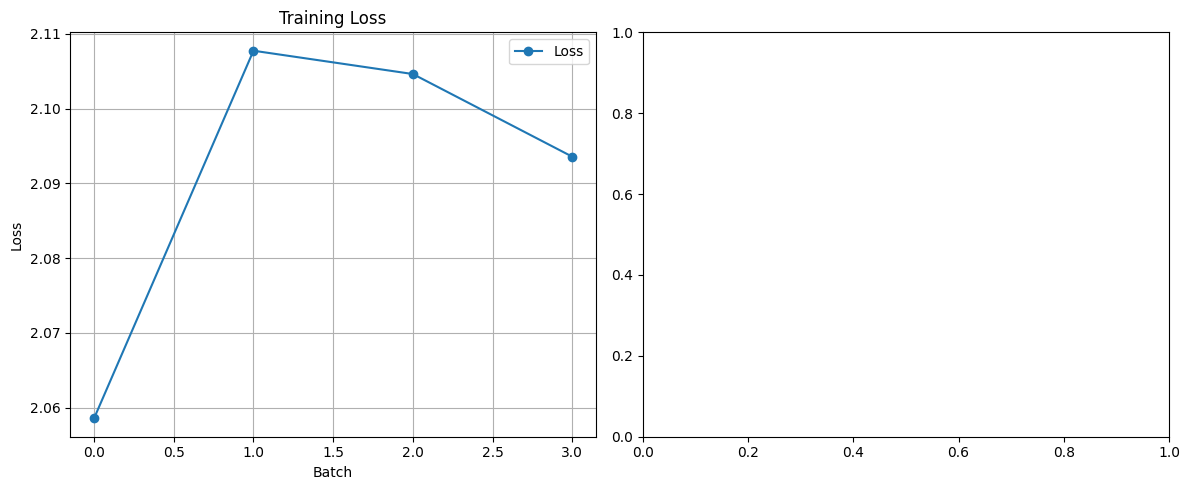

epoch 1:  98%|█████████▊| 46/47 [04:22<00:05,  5.70s/it, epoch :1 , batch =0.979]


,epoch,loss,val_loss,IOUMetric,PerClassIOUMetric,Dice_Coefficent_matrics,PerClassDiceCoefficientMatrics,Pixel_accurcy_metrics,IOUMetric_val,PerClassIOUMetric_val,Dice_Coefficent_matrics_val,PerClassDiceCoefficientMatrics_val,Pixel_accurcy_metrics_val
0,1,"tf.Tensor(2.159552, shape=(), dtype=float32)","tf.Tensor(17.35109, shape=(), dtype=float32)","tf.Tensor(nan, shape=(), dtype=float32)","(tf.Tensor(nan, shape=(), dtype=float32), tf.T...","tf.Tensor(nan, shape=(), dtype=float32)","(tf.Tensor(nan, shape=(), dtype=float32), tf.T...","tf.Tensor(nan, shape=(), dtype=float32)","tf.Tensor(0.017100299, shape=(), dtype=float32)","(tf.Tensor(0.05283581, shape=(), dtype=float32...","tf.Tensor(0.028009027, shape=(), dtype=float32)","(tf.Tensor(0.100368574, shape=(), dtype=float3...","tf.Tensor(0.079821154, shape=(), dtype=float32)"


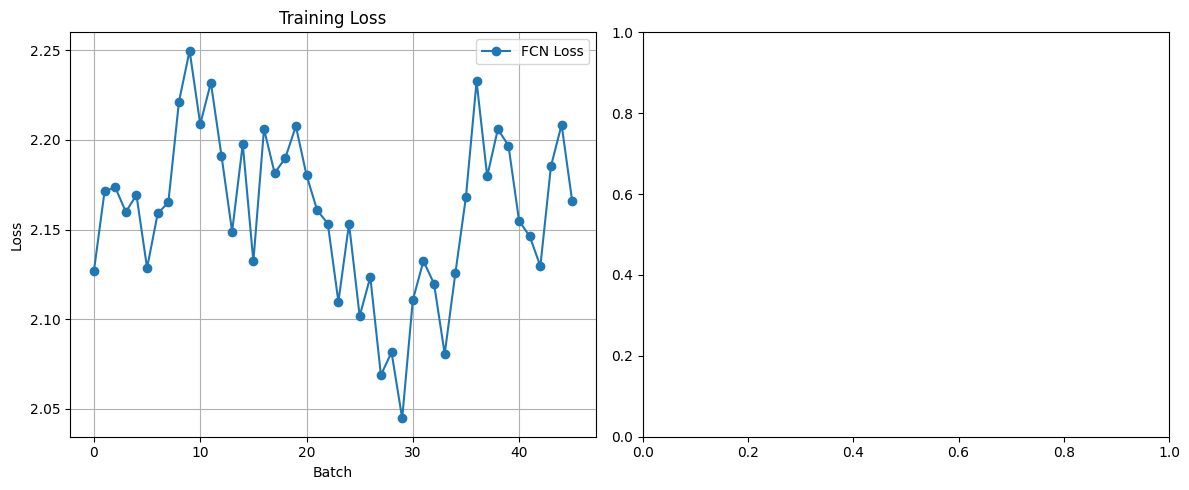

Epoch begins : 2


epoch 2:   0%|          | 0/47 [00:00<?, ?it/s]

epoch 2:  98%|█████████▊| 46/47 [01:55<00:02,  2.52s/it, epoch :2 , batch =0.979]


,epoch,loss,val_loss,IOUMetric,PerClassIOUMetric,Dice_Coefficent_matrics,PerClassDiceCoefficientMatrics,Pixel_accurcy_metrics,IOUMetric_val,PerClassIOUMetric_val,Dice_Coefficent_matrics_val,PerClassDiceCoefficientMatrics_val,Pixel_accurcy_metrics_val
0,2,"tf.Tensor(2.1581905, shape=(), dtype=float32)","tf.Tensor(17.326344, shape=(), dtype=float32)","tf.Tensor(nan, shape=(), dtype=float32)","(tf.Tensor(nan, shape=(), dtype=float32), tf.T...","tf.Tensor(nan, shape=(), dtype=float32)","(tf.Tensor(nan, shape=(), dtype=float32), tf.T...","tf.Tensor(nan, shape=(), dtype=float32)","tf.Tensor(0.017742492, shape=(), dtype=float32)","(tf.Tensor(0.06385461, shape=(), dtype=float32...","tf.Tensor(0.029355558, shape=(), dtype=float32)","(tf.Tensor(0.120043874, shape=(), dtype=float3...","tf.Tensor(0.07808376, shape=(), dtype=float32)"


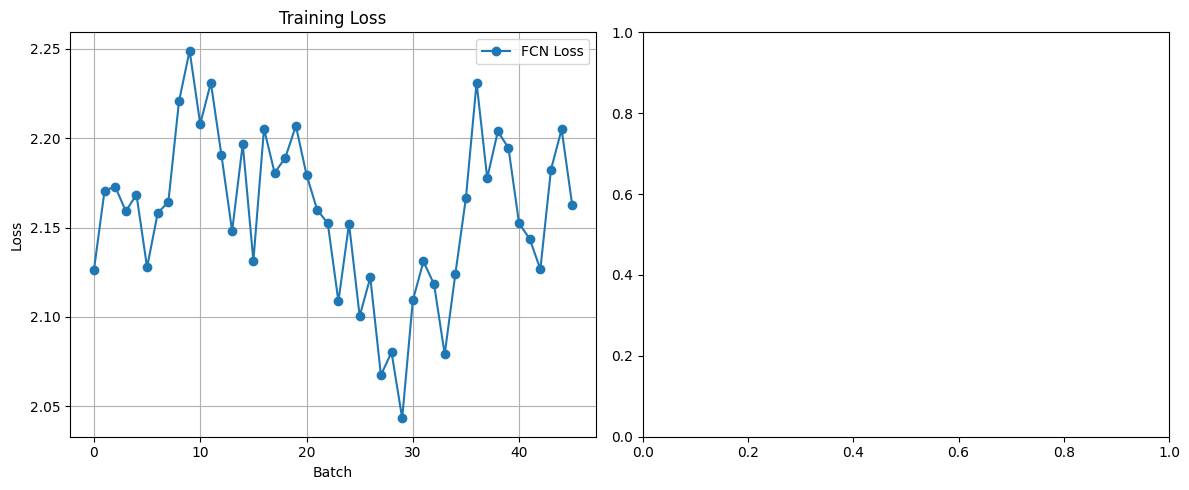

Epoch begins : 3


epoch 3:   0%|          | 0/47 [00:00<?, ?it/s]

epoch 3:  98%|█████████▊| 46/47 [01:55<00:02,  2.51s/it, epoch :3 , batch =0.979]


,epoch,loss,val_loss,IOUMetric,PerClassIOUMetric,Dice_Coefficent_matrics,PerClassDiceCoefficientMatrics,Pixel_accurcy_metrics,IOUMetric_val,PerClassIOUMetric_val,Dice_Coefficent_matrics_val,PerClassDiceCoefficientMatrics_val,Pixel_accurcy_metrics_val
0,3,"tf.Tensor(2.1524932, shape=(), dtype=float32)","tf.Tensor(17.265001, shape=(), dtype=float32)","tf.Tensor(nan, shape=(), dtype=float32)","(tf.Tensor(nan, shape=(), dtype=float32), tf.T...","tf.Tensor(nan, shape=(), dtype=float32)","(tf.Tensor(nan, shape=(), dtype=float32), tf.T...","tf.Tensor(nan, shape=(), dtype=float32)","tf.Tensor(0.018521601, shape=(), dtype=float32)","(tf.Tensor(0.07289296, shape=(), dtype=float32...","tf.Tensor(0.030608693, shape=(), dtype=float32)","(tf.Tensor(0.13588113, shape=(), dtype=float32...","tf.Tensor(0.08777216, shape=(), dtype=float32)"


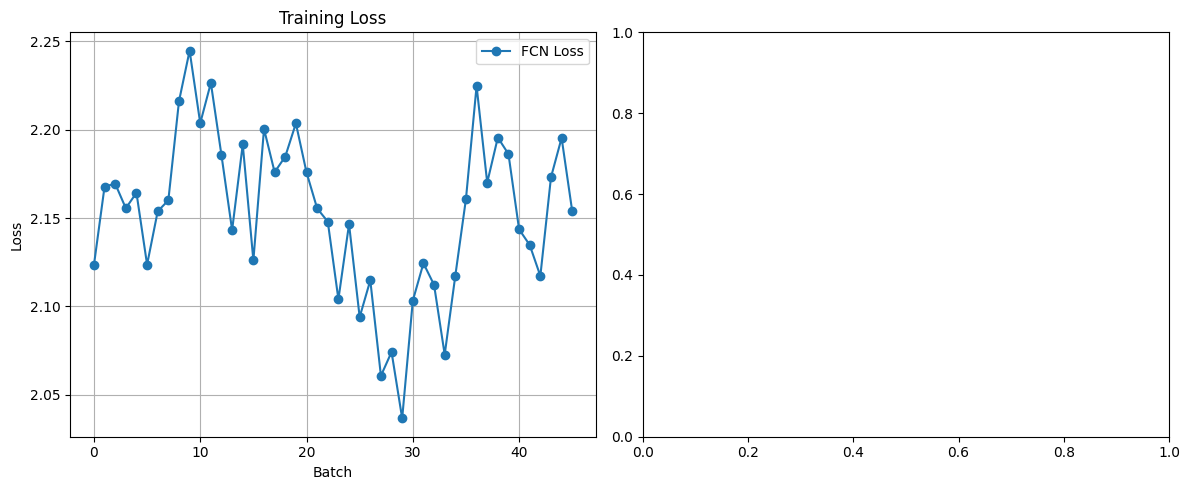

Epoch begins : 4


epoch 4:   0%|          | 0/47 [00:00<?, ?it/s]

epoch 4:  98%|█████████▊| 46/47 [01:54<00:02,  2.49s/it, epoch :4 , batch =0.979]


,epoch,loss,val_loss,IOUMetric,PerClassIOUMetric,Dice_Coefficent_matrics,PerClassDiceCoefficientMatrics,Pixel_accurcy_metrics,IOUMetric_val,PerClassIOUMetric_val,Dice_Coefficent_matrics_val,PerClassDiceCoefficientMatrics_val,Pixel_accurcy_metrics_val
0,4,"tf.Tensor(2.1436303, shape=(), dtype=float32)","tf.Tensor(17.196331, shape=(), dtype=float32)","tf.Tensor(nan, shape=(), dtype=float32)","(tf.Tensor(nan, shape=(), dtype=float32), tf.T...","tf.Tensor(nan, shape=(), dtype=float32)","(tf.Tensor(nan, shape=(), dtype=float32), tf.T...","tf.Tensor(nan, shape=(), dtype=float32)","tf.Tensor(0.01954251, shape=(), dtype=float32)","(tf.Tensor(0.083177395, shape=(), dtype=float3...","tf.Tensor(0.032333665, shape=(), dtype=float32)","(tf.Tensor(0.15358037, shape=(), dtype=float32...","tf.Tensor(0.097988695, shape=(), dtype=float32)"


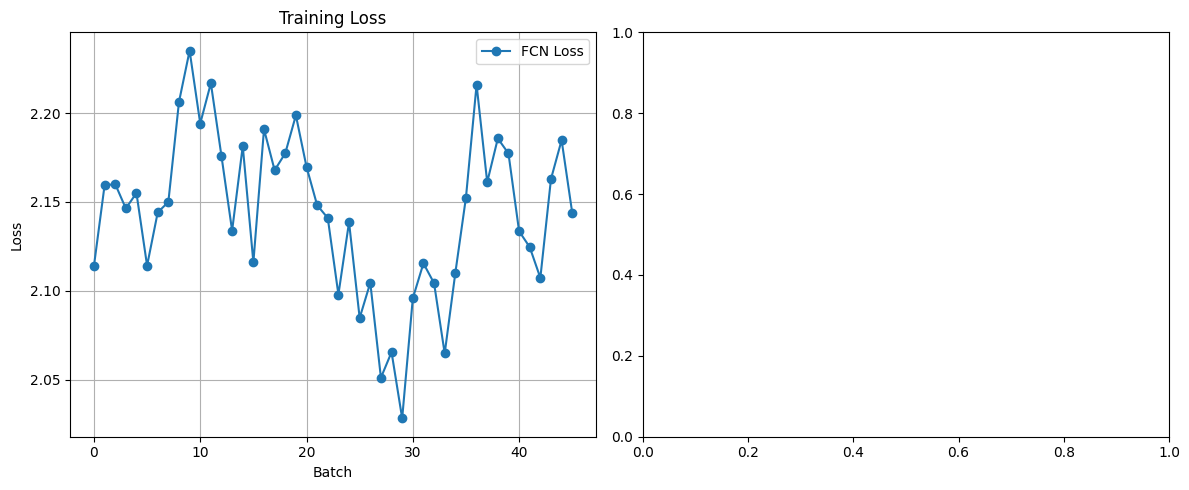

Epoch begins : 5


epoch 5:   0%|          | 0/47 [00:00<?, ?it/s]

epoch 5:  98%|█████████▊| 46/47 [01:55<00:02,  2.50s/it, epoch :5 , batch =0.979]


,epoch,loss,val_loss,IOUMetric,PerClassIOUMetric,Dice_Coefficent_matrics,PerClassDiceCoefficientMatrics,Pixel_accurcy_metrics,IOUMetric_val,PerClassIOUMetric_val,Dice_Coefficent_matrics_val,PerClassDiceCoefficientMatrics_val,Pixel_accurcy_metrics_val
0,5,"tf.Tensor(2.1339889, shape=(), dtype=float32)","tf.Tensor(17.116892, shape=(), dtype=float32)","tf.Tensor(nan, shape=(), dtype=float32)","(tf.Tensor(nan, shape=(), dtype=float32), tf.T...","tf.Tensor(nan, shape=(), dtype=float32)","(tf.Tensor(nan, shape=(), dtype=float32), tf.T...","tf.Tensor(nan, shape=(), dtype=float32)","tf.Tensor(0.01989684, shape=(), dtype=float32)","(tf.Tensor(0.0866929, shape=(), dtype=float32)...","tf.Tensor(0.03298802, shape=(), dtype=float32)","(tf.Tensor(0.15955359, shape=(), dtype=float32...","tf.Tensor(0.10426469, shape=(), dtype=float32)"


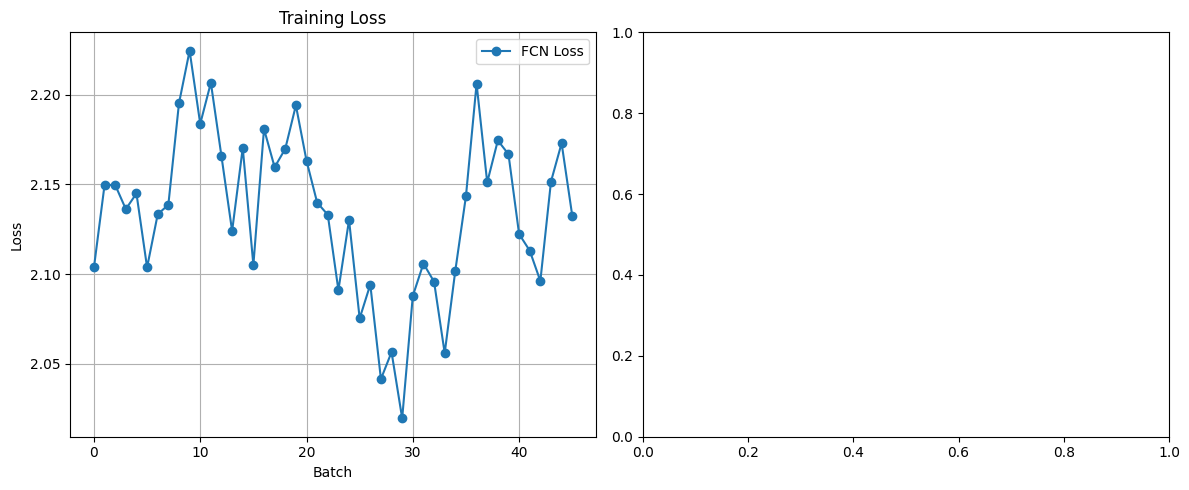

Epoch begins : 6


epoch 6:   0%|          | 0/47 [00:00<?, ?it/s]

epoch 6:  98%|█████████▊| 46/47 [01:55<00:02,  2.50s/it, epoch :6 , batch =0.979]


,epoch,loss,val_loss,IOUMetric,PerClassIOUMetric,Dice_Coefficent_matrics,PerClassDiceCoefficientMatrics,Pixel_accurcy_metrics,IOUMetric_val,PerClassIOUMetric_val,Dice_Coefficent_matrics_val,PerClassDiceCoefficientMatrics_val,Pixel_accurcy_metrics_val
0,6,"tf.Tensor(2.1225855, shape=(), dtype=float32)","tf.Tensor(17.020388, shape=(), dtype=float32)","tf.Tensor(nan, shape=(), dtype=float32)","(tf.Tensor(nan, shape=(), dtype=float32), tf.T...","tf.Tensor(nan, shape=(), dtype=float32)","(tf.Tensor(nan, shape=(), dtype=float32), tf.T...","tf.Tensor(nan, shape=(), dtype=float32)","tf.Tensor(0.01992466, shape=(), dtype=float32)","(tf.Tensor(0.086911984, shape=(), dtype=float3...","tf.Tensor(0.03305777, shape=(), dtype=float32)","(tf.Tensor(0.15992461, shape=(), dtype=float32...","tf.Tensor(0.10935781, shape=(), dtype=float32)"


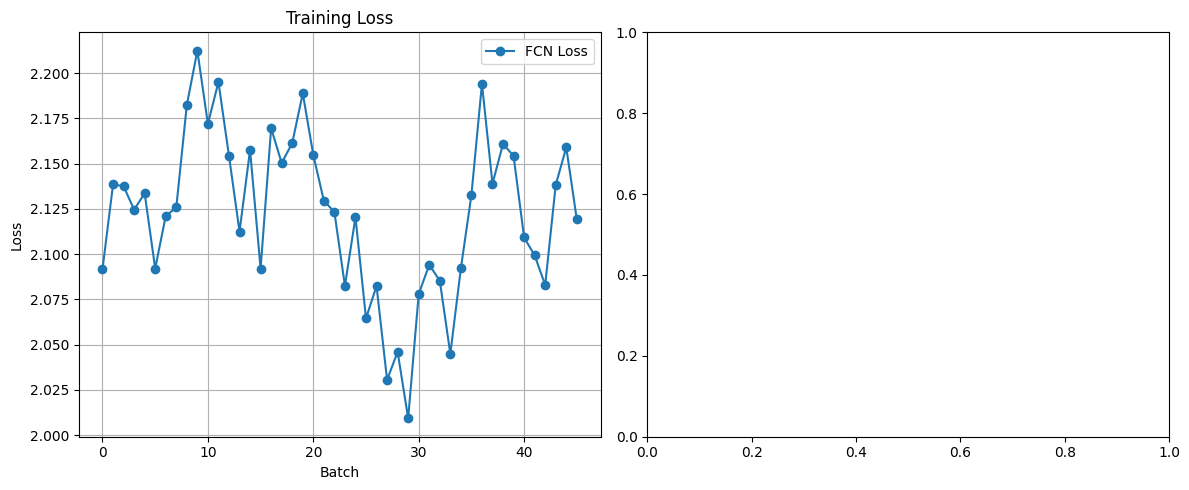

Epoch begins : 7


epoch 7:   0%|          | 0/47 [00:00<?, ?it/s]

epoch 7:  98%|█████████▊| 46/47 [01:54<00:02,  2.49s/it, epoch :7 , batch =0.979]


,epoch,loss,val_loss,IOUMetric,PerClassIOUMetric,Dice_Coefficent_matrics,PerClassDiceCoefficientMatrics,Pixel_accurcy_metrics,IOUMetric_val,PerClassIOUMetric_val,Dice_Coefficent_matrics_val,PerClassDiceCoefficientMatrics_val,Pixel_accurcy_metrics_val
0,7,"tf.Tensor(2.1088114, shape=(), dtype=float32)","tf.Tensor(16.904696, shape=(), dtype=float32)","tf.Tensor(nan, shape=(), dtype=float32)","(tf.Tensor(nan, shape=(), dtype=float32), tf.T...","tf.Tensor(nan, shape=(), dtype=float32)","(tf.Tensor(nan, shape=(), dtype=float32), tf.T...","tf.Tensor(nan, shape=(), dtype=float32)","tf.Tensor(0.0201299, shape=(), dtype=float32)","(tf.Tensor(0.086992815, shape=(), dtype=float3...","tf.Tensor(0.033421572, shape=(), dtype=float32)","(tf.Tensor(0.16006145, shape=(), dtype=float32...","tf.Tensor(0.11480194, shape=(), dtype=float32)"


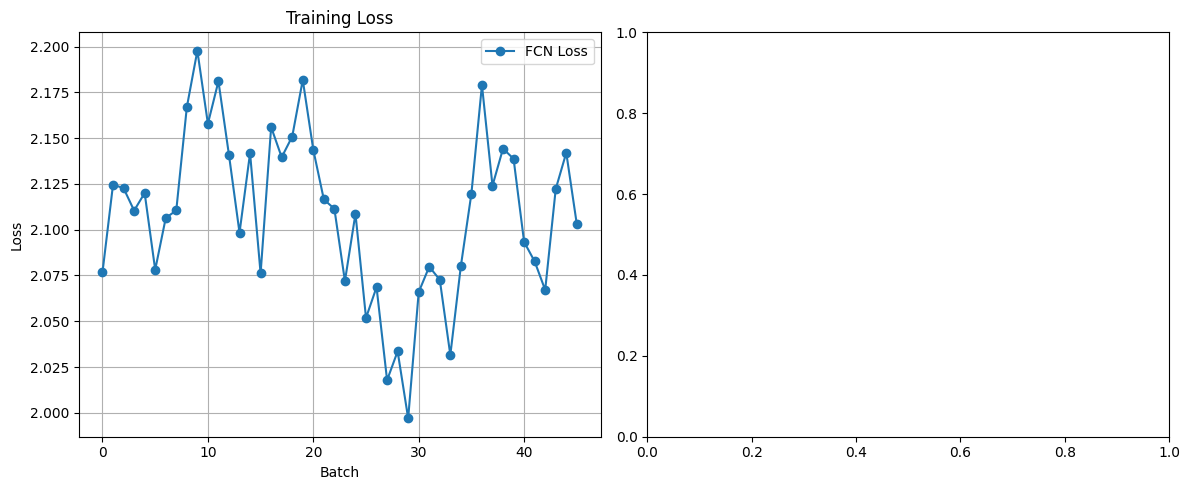

Epoch begins : 8


epoch 8:   0%|          | 0/47 [00:00<?, ?it/s]

epoch 8:   9%|▊         | 4/47 [00:08<01:25,  1.99s/it, epoch :8 , batch =0.0851]

In [ ]:
with strategy.scope():
  stop_training =False
  start=fcn_master_callback.on_train_begin()
  for epoch in range(start , 250 ):
    fcn_master_callback.on_epoch_begin(epoch)
    losses = train_fcn_for_one_epoch(epoch)
    val_losses = val_fcn_for_one_epoch()
    avg_loss = tf.reduce_mean(losses)
    avg_val_loss = tf.reduce_mean(val_losses)
    data = {

                'loss' : avg_loss ,
                'val_loss' : avg_val_loss ,
                'metrics': {
                    'IOUMetric' : fcn_IOUMetric.result(),
                    'PerClassIOUMetric' : fcn_PerClassIOUMetric.result(),
                    'Dice_Coefficent_matrics' : fcn_Dice_Coefficent_matrics.result(),
                    'PerClassDiceCoefficientMatrics' : fcn_PerClassDiceCoefficientMatrics.result() ,
                    'Pixel_accurcy_metrics' : fcn_Pixel_accurcy_metrics.result(),

                    'IOUMetric_val' : fcn_IOUMetric_val.result(),
                    'PerClassIOUMetric_val' : fcn_PerClassIOUMetric_val.result(),
                    'Dice_Coefficent_matrics_val' : fcn_Dice_Coefficent_matrics_val.result(),
                    'PerClassDiceCoefficientMatrics_val' : fcn_PerClassDiceCoefficientMatrics_val.result() ,
                    'Pixel_accurcy_metrics_val' : fcn_Pixel_accurcy_metrics_val.result()

            },
        }
    fcn_IOUMetric.reset_state()
    fcn_IOUMetric_val.reset_state()
    fcn_PerClassIOUMetric.reset_state()
    fcn_PerClassIOUMetric_val.reset_state()
    fcn_Dice_Coefficent_matrics.reset_state()
    fcn_Dice_Coefficent_matrics_val.reset_state()
    fcn_PerClassDiceCoefficientMatrics.reset_state()
    fcn_PerClassDiceCoefficientMatrics_val.reset_state()
    fcn_Pixel_accurcy_metrics.reset_state()
    fcn_Pixel_accurcy_metrics_val.reset_state()



    stop_training=fcn_master_callback.on_epoch_end(epoch=epoch , data= data)
    if stop_training :
      break

In [ ]:
with strategy.scope():
  stop_training =False
  start=unet_master_callback.on_train_begin()
  for epoch in range(start , 250 ):
    unet_master_callback.on_epoch_begin(epoch)
    losses = train_unet_for_one_epoch(epoch)
    val_losses = val_unet_for_one_epoch()
    data = {

                'loss' : losses ,
                'val_loss' : val_losses ,
                'metrics': {
                    'IOUMetric' : unet_IOUMetric.result(),
                    'PerClassIOUMetric' : unet_PerClassIOUMetric.result(),
                    'Dice_Coefficent_matrics' : unet_Dice_Coefficent_matrics.result(),
                    'PerClassDiceCoefficientMatrics' : unet_PerClassDiceCoefficientMatrics.result() ,
                    'Pixel_accurcy_metrics' : unet_Pixel_accurcy_metrics.result(),

                    'IOUMetric_val' : unet_IOUMetric_val.result(),
                    'PerClassIOUMetric_val' : unet_PerClassIOUMetric_val.result(),
                    'Dice_Coefficent_matrics_val' : unet_Dice_Coefficent_matrics_val.result(),
                    'PerClassDiceCoefficientMatrics_val' : unet_PerClassDiceCoefficientMatrics_val.result() ,
                    'Pixel_accurcy_metrics_val' : unet_Pixel_accurcy_metrics_val.result()

            },
        }
    unet_IOUMetric.reset_state()
    unet_IOUMetric_val.reset_state()
    unet_PerClassIOUMetric.reset_state()
    unet_PerClassIOUMetric_val.reset_state()
    unet_Dice_Coefficent_matrics.reset_state()
    unet_Dice_Coefficent_matrics_val.reset_state()
    unet_PerClassDiceCoefficientMatrics.reset_state()
    unet_PerClassDiceCoefficientMatrics_val.reset_state()
    unet_Pixel_accurcy_metrics.reset_state()
    unet_Pixel_accurcy_metrics_val.reset_state()



    stop_training=unet_master_callback.on_epoch_end(epoch=epoch , data= data)
    if stop_training :
      break

In [ ]:
with strategy.scope():
  stop_training =False
  start=unet_plus_plus_master_callback.on_train_begin()
  for epoch in range(start , 250 ):
    unet_plus_plus_master_callback.on_epoch_begin(epoch)
    losses = train_unet_plus_plus_for_one_epoch(epoch)
    val_losses = val_unet_plus_plus_for_one_epoch()
    data = {

                'loss' : losses ,
                'val_loss' : val_losses ,
                'metrics': {
                    'IOUMetric' : unet_plus_plus_IOUMetric.result(),
                    'PerClassIOUMetric' : unet_plus_plus_PerClassIOUMetric.result(),
                    'Dice_Coefficent_matrics' : unet_plus_plus_Dice_Coefficent_matrics.result(),
                    'PerClassDiceCoefficientMatrics' : unet_plus_plus_PerClassDiceCoefficientMatrics.result() ,
                    'Pixel_accurcy_metrics' : unet_plus_plus_Pixel_accurcy_metrics.result(),

                    'IOUMetric_val' : unet_plus_plus_IOUMetric_val.result(),
                    'PerClassIOUMetric_val' : unet_plus_plus_PerClassIOUMetric_val.result(),
                    'Dice_Coefficent_matrics_val' : unet_plus_plus_Dice_Coefficent_matrics_val.result(),
                    'PerClassDiceCoefficientMatrics_val' : unet_plus_plus_PerClassDiceCoefficientMatrics_val.result() ,
                    'Pixel_accurcy_metrics_val' : unet_plus_plus_Pixel_accurcy_metrics_val.result()

            },
        }
    unet_plus_plus_IOUMetric.reset_state()
    unet_plus_plus_IOUMetric_val.reset_state()
    unet_plus_plus_PerClassIOUMetric.reset_state()
    unet_plus_plus_PerClassIOUMetric_val.reset_state()
    unet_plus_plus_Dice_Coefficent_matrics.reset_state()
    unet_plus_plus_Dice_Coefficent_matrics_val.reset_state()
    unet_plus_plus_PerClassDiceCoefficientMatrics.reset_state()
    unet_plus_plus_PerClassDiceCoefficientMatrics_val.reset_state()
    unet_plus_plus_Pixel_accurcy_metrics.reset_state()
    unet_plus_plus_Pixel_accurcy_metrics_val.reset_state()



    stop_training=unet_plus_plus_master_callback.on_epoch_end(epoch=epoch , data= data)
    if stop_training :
      break